The dataset concerns the subscription to 'reMarkable Connect' which allows to share notes across devices with unlimited cloud storage and device protection

In [203]:
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np
import plotly.graph_objects as go
from sklearn.model_selection import train_test_split
import collections
from imblearn.over_sampling import SMOTE
from sklearn.preprocessing import MinMaxScaler
from sklearn import linear_model
from sklearn.model_selection import learning_curve
from sklearn import metrics
from sklearn.linear_model import LogisticRegression
from sklearn import tree
from sklearn.model_selection import GridSearchCV
import graphviz
from sklearn.ensemble import RandomForestClassifier
from sklearn.neural_network import MLPClassifier
from sklearn.naive_bayes import GaussianNB
from sklearn import svm
from sklearn.neighbors import KNeighborsClassifier
from mpl_toolkits.mplot3d import Axes3D
from IPython.display import HTML, display

Settings:

In [204]:
pd.set_option('display.max_columns', 55)

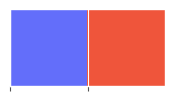

In [205]:
#Color Palette for the plots
flatui = ["#636EFA", "#EF553B"]
sns.set_palette(flatui)
sns.palplot(sns.color_palette())

## Loading the Data

In [206]:
churn = pd.read_csv('remarkable_churn.csv')

## Understanding the dataset

In [207]:
churn.head()

customer_id  gender  purchased_by_employer has_newest_device  \
0  7590-VHVEG  Female                      0               Yes   
1  5575-GNVDE    Male                      0                No   
2  3668-QPYBK    Male                      0                No   
3  7795-CFOCW    Male                      0                No   
4  9237-HQITU  Female                      0                No   

   months_since_purchase integrations_activated integration_types  \
0                      1                     No            gdrive   
1                     34                    Yes            gdrive   
2                      2                    Yes            gdrive   
3                     45                     No            gdrive   
4                      2                    Yes           dropbox   

  online_backup device_insurance tech_support send_by_email share_screen  \
0           Yes               No           No            No           No   
1            No              Yes           No            No           No   
2           Yes               No           No            No           No   
3            No              Yes          Yes            No           No   
4            No               No           No            No           No   

  subscription_type recurring_payment             payment_method  \
0    Month-to-month               Yes           Electronic check   
1          One year                No               Mailed check   
2    Month-to-month               Yes               Mailed check   
3          One year                No  Bank transfer (automatic)   
4    Month-to-month               Yes           Electronic check   

   monthly_charges total_charges churn  
0            29.85         29.85    No  
1            56.95        1889.5    No  
2            53.85        108.15   Yes  
3            42.30       1840.75    No  
4            70.70        151.65   Yes

Interpretation:
A customer with a customer ID '7590-VHVEG' has the gender female, has the newest device (reMarkable ) which hasn't been purchased by the employer, they bought it last month and there's no integration activated, there's some online backup, but no device insurance nor tech support nor sends things by email or shares the screen. The payment is recurring and is done on a monthly cadence through Electronic Check of 29.85 and thte total charge is of the same value since the person only had the device for 1 month and that person didn't churn at the time when the dataset was extracted.

In [208]:
churn.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 7043 entries, 0 to 7042
Data columns (total 18 columns):
 #   Column                  Non-Null Count  Dtype  
---  ------                  --------------  -----  
 0   customer_id             7043 non-null   object 
 1   gender                  7043 non-null   object 
 2   purchased_by_employer   7043 non-null   int64  
 3   has_newest_device       7043 non-null   object 
 4   months_since_purchase   7043 non-null   int64  
 5   integrations_activated  7043 non-null   object 
 6   integration_types       7043 non-null   object 
 7   online_backup           7043 non-null   object 
 8   device_insurance        7043 non-null   object 
 9   tech_support            7043 non-null   object 
 10  send_by_email           7043 non-null   object 
 11  share_screen            7043 non-null   object 
 12  subscription_type       7043 non-null   object 
 13  recurring_payment       7043 non-null   object 
 14  payment_method          7043 non-null   

We have 2 integer variables - purchased by employer which is a binary variable and months since purchase. 

We have one float variable which is monthly charges.

Finally, there's 15 objects where 'total_charges' should be transformed into float.

- Customer ID: Identifier of the customer (no repeated IDs); <br>
- Gender: Gender of the customer - male or female <br>
- Purchased by Employer: Binary variable describing if the product was bought by employer or not <br>
- Has newest device: Binary variable describing if the customer has the latest remarkable version of the product <br>
- Integrations activated: Binary variable describing if the customer has integrations activated <br>
- Integration types: A follow up to the previous variable detailing if the integration is with Dropbox, Google Drive or Custom <br>
- Online backup: Binary variable describing if the reMarkable has an online backup or not <br>
- Device insurance: Binary variable describing if the reMarkable device has insurance or not <br>
- Tech support: Binary variable describing if the user received technical support or not (TBC) <br>
- Send by Email: Binary variable describing if the user send something by email or not (TBC) <br>
- Share Screen: Binary variable describing if the user shares their screen or not (TBC) <br>
- Subscription Type: If the user subscribed to Connect through monthly payments, paid for 1 year or two years (potentially considering the free trial of 1 year?) <br>
- Recurring Payment: Binary variable describing if the user has recurring payments or not <br>
- Payment Method: If the payment of the subscription was done through Electronic Check, Mailed Check, Automatic Bank Transfer or Automatic Credit Card debit <br>
- Total Charges: Total charges of the subscription service (TBC) <br>
- Churn: The dependent variable, a binary variable indicating if the user churned or not



In [209]:
churn['total_charges'] = pd.to_numeric(churn['total_charges'], errors='coerce')

Checking for missing values:

In [210]:
churn.isna().sum()

customer_id                0
gender                     0
purchased_by_employer      0
has_newest_device          0
months_since_purchase      0
integrations_activated     0
integration_types          0
online_backup              0
device_insurance           0
tech_support               0
send_by_email              0
share_screen               0
subscription_type          0
recurring_payment          0
payment_method             0
monthly_charges            0
total_charges             11
churn                      0
dtype: int64

There's 11 missing values in total_charges

In [211]:
churn[churn['total_charges'].isna()]

customer_id  gender  purchased_by_employer has_newest_device  \
488   4472-LVYGI  Female                      0               Yes   
753   3115-CZMZD    Male                      0                No   
936   5709-LVOEQ  Female                      0               Yes   
1082  4367-NUYAO    Male                      0               Yes   
1340  1371-DWPAZ  Female                      0               Yes   
3331  7644-OMVMY    Male                      0               Yes   
3826  3213-VVOLG    Male                      0               Yes   
4380  2520-SGTTA  Female                      0               Yes   
5218  2923-ARZLG    Male                      0               Yes   
6670  4075-WKNIU  Female                      0               Yes   
6754  2775-SEFEE    Male                      0                No   

      months_since_purchase integrations_activated integration_types  \
488                       0                     No            gdrive   
753                       0                    Yes            custom   
936                       0                    Yes            gdrive   
1082                      0                    Yes            custom   
1340                      0                     No            gdrive   
3331                      0                    Yes            custom   
3826                      0                    Yes            custom   
4380                      0                    Yes            custom   
5218                      0                    Yes            custom   
6670                      0                    Yes            gdrive   
6754                      0                    Yes            gdrive   

     online_backup device_insurance tech_support send_by_email share_screen  \
488             No              Yes          Yes           Yes           No   
753             No               No           No            No           No   
936            Yes              Yes           No           Yes          Yes   
1082            No               No           No            No           No   
1340           Yes              Yes          Yes           Yes           No   
3331            No               No           No            No           No   
3826            No               No           No            No           No   
4380            No               No           No            No           No   
5218            No               No           No            No           No   
6670           Yes              Yes          Yes           Yes           No   
6754           Yes               No          Yes            No           No   

     subscription_type recurring_payment             payment_method  \
488           Two year               Yes  Bank transfer (automatic)   
753           Two year                No               Mailed check   
936           Two year                No               Mailed check   
1082          Two year                No               Mailed check   
1340          Two year                No    Credit card (automatic)   
3331          Two year                No               Mailed check   
3826          Two year                No               Mailed check   
4380          Two year                No               Mailed check   
5218          One year               Yes               Mailed check   
6670          Two year                No               Mailed check   
6754          Two year               Yes  Bank transfer (automatic)   

      monthly_charges  total_charges churn  
488             52.55            NaN    No  
753             20.25            NaN    No  
936             80.85            NaN    No  
1082            25.75            NaN    No  
1340            56.05            NaN    No  
3331            19.85            NaN    No  
3826            25.35            NaN    No  
4380            20.00            NaN    No  
5218            19.70            NaN    No  
6670            73.35            NaN    No  
6754          

In [212]:
churn[churn['months_since_purchase'] == 0]

customer_id  gender  purchased_by_employer has_newest_device  \
488   4472-LVYGI  Female                      0               Yes   
753   3115-CZMZD    Male                      0                No   
936   5709-LVOEQ  Female                      0               Yes   
1082  4367-NUYAO    Male                      0               Yes   
1340  1371-DWPAZ  Female                      0               Yes   
3331  7644-OMVMY    Male                      0               Yes   
3826  3213-VVOLG    Male                      0               Yes   
4380  2520-SGTTA  Female                      0               Yes   
5218  2923-ARZLG    Male                      0               Yes   
6670  4075-WKNIU  Female                      0               Yes   
6754  2775-SEFEE    Male                      0                No   

      months_since_purchase integrations_activated integration_types  \
488                       0                     No            gdrive   
753                       0                    Yes            custom   
936                       0                    Yes            gdrive   
1082                      0                    Yes            custom   
1340                      0                     No            gdrive   
3331                      0                    Yes            custom   
3826                      0                    Yes            custom   
4380                      0                    Yes            custom   
5218                      0                    Yes            custom   
6670                      0                    Yes            gdrive   
6754                      0                    Yes            gdrive   

     online_backup device_insurance tech_support send_by_email share_screen  \
488             No              Yes          Yes           Yes           No   
753             No               No           No            No           No   
936            Yes              Yes           No           Yes          Yes   
1082            No               No           No            No           No   
1340           Yes              Yes          Yes           Yes           No   
3331            No               No           No            No           No   
3826            No               No           No            No           No   
4380            No               No           No            No           No   
5218            No               No           No            No           No   
6670           Yes              Yes          Yes           Yes           No   
6754           Yes               No          Yes            No           No   

     subscription_type recurring_payment             payment_method  \
488           Two year               Yes  Bank transfer (automatic)   
753           Two year                No               Mailed check   
936           Two year                No               Mailed check   
1082          Two year                No               Mailed check   
1340          Two year                No    Credit card (automatic)   
3331          Two year                No               Mailed check   
3826          Two year                No               Mailed check   
4380          Two year                No               Mailed check   
5218          One year               Yes               Mailed check   
6670          Two year                No               Mailed check   
6754          Two year               Yes  Bank transfer (automatic)   

      monthly_charges  total_charges churn  
488             52.55            NaN    No  
753             20.25            NaN    No  
936             80.85            NaN    No  
1082            25.75            NaN    No  
1340            56.05            NaN    No  
3331            19.85            NaN    No  
3826            25.35            NaN    No  
4380            20.00            NaN    No  
5218            19.70            NaN    No  
6670            73.35            NaN    No  
6754          

Total Charges is NaN for those whose months_since_purchase is equal to 0, so let's replace the values of NaN by 0

In [213]:
churn['total_charges'] = churn['total_charges'].fillna(0)

## Exploratory Data Analysis

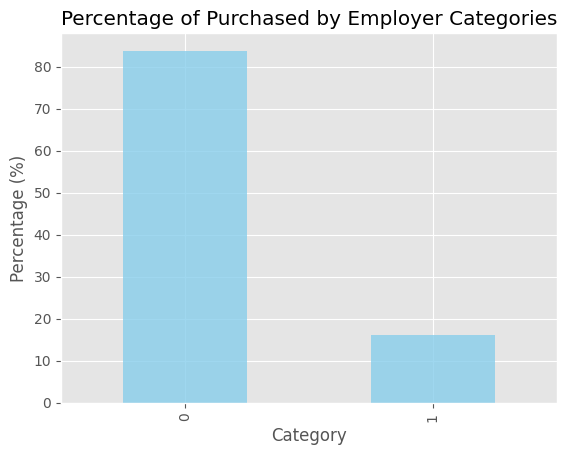

In [214]:
# Calculate the percentage of each category
category_counts = churn['purchased_by_employer'].value_counts(normalize=True) * 100

# Create bar chart
category_counts.plot(kind='bar', color='skyblue', alpha=0.8)

# Add titles and labels
plt.title('Percentage of Purchased by Employer Categories')
plt.xlabel('Category')
plt.ylabel('Percentage (%)')

# Show plot
plt.show()

About 80% of the purchases are made by non-employers

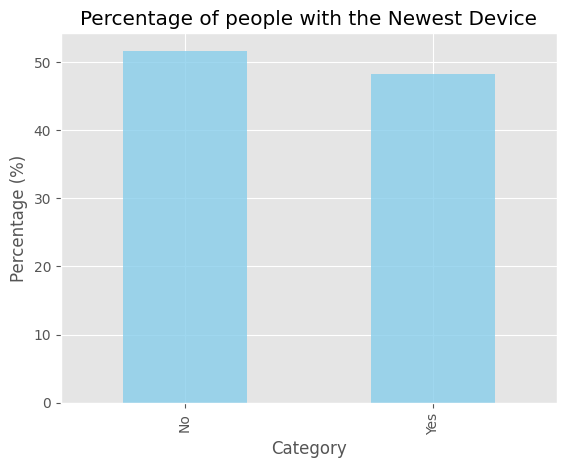

In [215]:
# Calculate the percentage of each category
category_counts = churn['has_newest_device'].value_counts(normalize=True) * 100

# Create bar chart
category_counts.plot(kind='bar', color='skyblue', alpha=0.8)

# Add titles and labels
plt.title('Percentage of people with the Newest Device')
plt.xlabel('Category')
plt.ylabel('Percentage (%)')

# Show plot
plt.show()

In regards to the newest device, it looks like it's split between almost 50% having the newest device (reMarkable 2) and 50% having the previous version

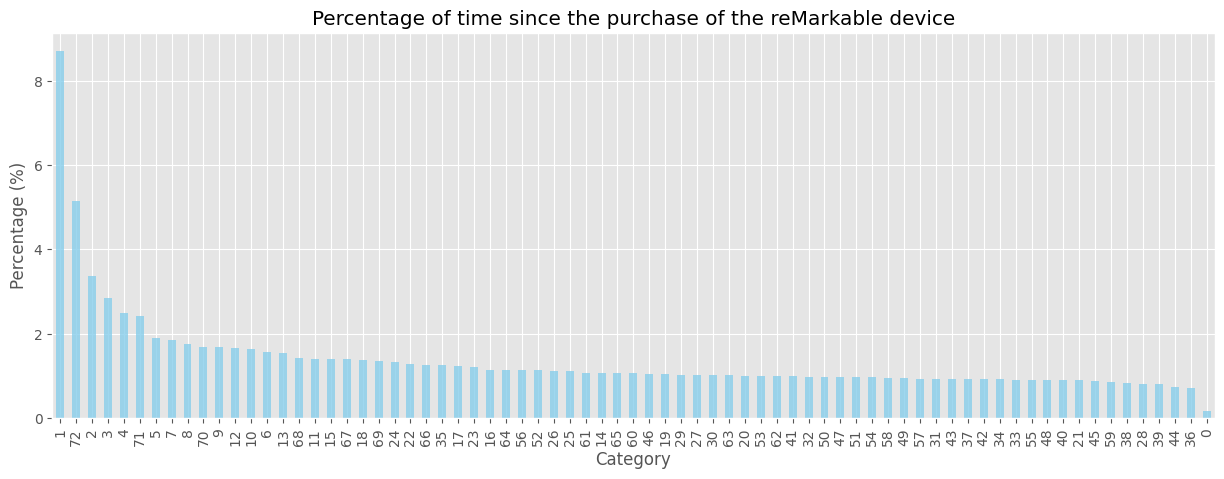

In [216]:
# Calculate the percentage of each category
category_counts = churn['months_since_purchase'].value_counts(normalize=True) * 100

plt.figure(figsize=(15, 5))  # You can adjust the size as needed

# Create bar chart
category_counts.plot(kind='bar', color='skyblue', alpha=0.8)

# Add titles and labels
plt.title('Percentage of time since the purchase of the reMarkable device')
plt.xlabel('Category')
plt.ylabel('Percentage (%)')

# Show plot
plt.show()

Interestingly, most people have bought their device only 1 month ago, followed by people who have bought it 72 months ago, meaning 6 years ago. If we assume the dataset is from August 2023, it would fit perfectly with the release date of reMarkable 1 which according to Wikipedia was on late 2017. 

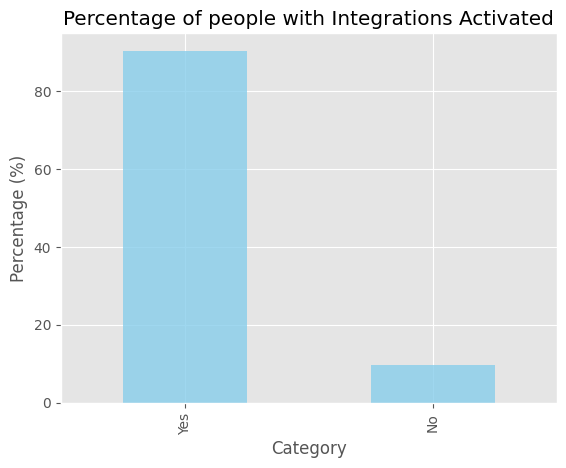

In [217]:
# Calculate the percentage of each category
category_counts = churn['integrations_activated'].value_counts(normalize=True) * 100

# Create bar chart
category_counts.plot(kind='bar', color='skyblue', alpha=0.8)

# Add titles and labels
plt.title('Percentage of people with Integrations Activated')
plt.xlabel('Category')
plt.ylabel('Percentage (%)')

# Show plot
plt.show()

Most users have integrations activated

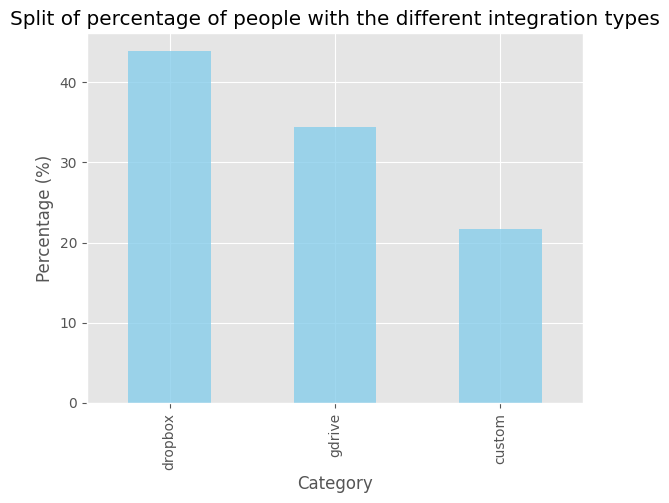

In [218]:
# Calculate the percentage of each category
category_counts = churn['integration_types'].value_counts(normalize=True) * 100

# Create bar chart
category_counts.plot(kind='bar', color='skyblue', alpha=0.8)

# Add titles and labels
plt.title('Split of percentage of people with the different integration types')
plt.xlabel('Category')
plt.ylabel('Percentage (%)')

# Show plot
plt.show()

Most of them have dropbox, followed by google drive and the least represented is custom integration

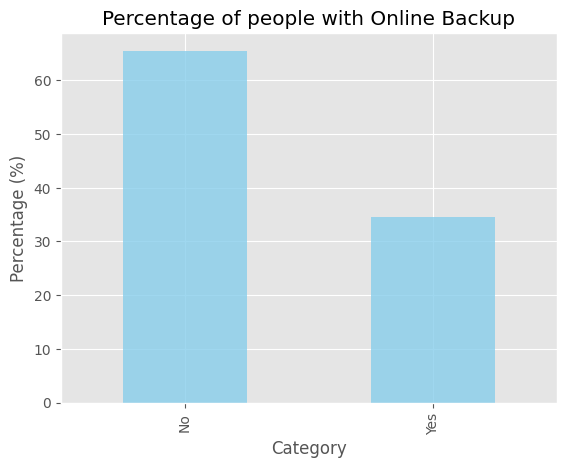

In [219]:
# Calculate the percentage of each category
category_counts = churn['online_backup'].value_counts(normalize=True) * 100

# Create bar chart
category_counts.plot(kind='bar', color='skyblue', alpha=0.8)

# Add titles and labels
plt.title('Percentage of people with Online Backup')
plt.xlabel('Category')
plt.ylabel('Percentage (%)')

# Show plot
plt.show()

Most users do not have online backup

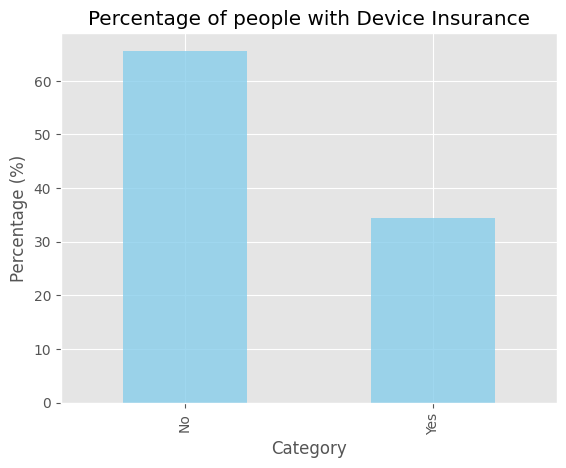

In [220]:
# Calculate the percentage of each category
category_counts = churn['device_insurance'].value_counts(normalize=True) * 100

# Create bar chart
category_counts.plot(kind='bar', color='skyblue', alpha=0.8)

# Add titles and labels
plt.title('Percentage of people with Device Insurance')
plt.xlabel('Category')
plt.ylabel('Percentage (%)')

# Show plot
plt.show()

Nor do they have device insurance

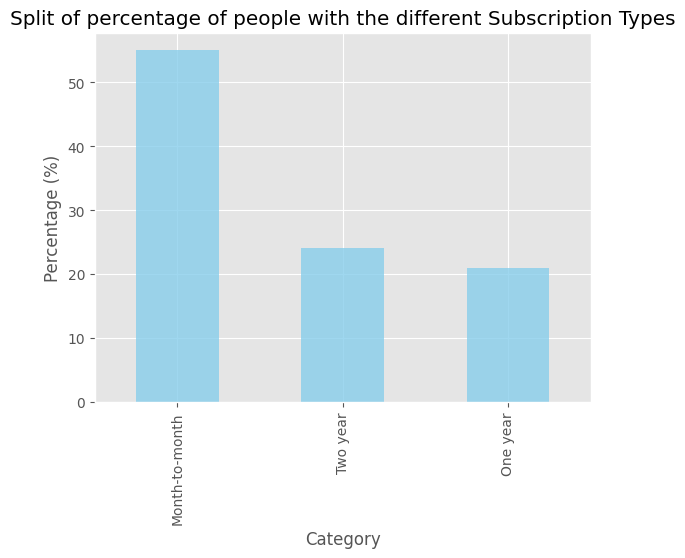

In [221]:
# Calculate the percentage of each category
category_counts = churn['subscription_type'].value_counts(normalize=True) * 100

# Create bar chart
category_counts.plot(kind='bar', color='skyblue', alpha=0.8)

# Add titles and labels
plt.title('Split of percentage of people with the different Subscription Types')
plt.xlabel('Category')
plt.ylabel('Percentage (%)')

# Show plot
plt.show()

Looks like most users have a monthly subscription, followed by users who pay a subscription that covers 2 years and finally with about the same percentage, users who pay a subscription that covers 1 year

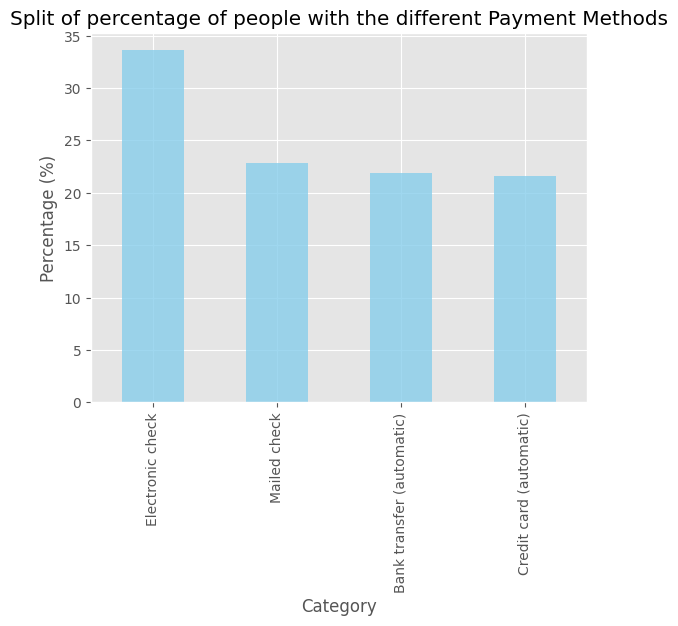

In [222]:
# Calculate the percentage of each category
category_counts = churn['payment_method'].value_counts(normalize=True) * 100

# Create bar chart
category_counts.plot(kind='bar', color='skyblue', alpha=0.8)

# Add titles and labels
plt.title('Split of percentage of people with the different Payment Methods')
plt.xlabel('Category')
plt.ylabel('Percentage (%)')

# Show plot
plt.show()

Most users seem to pay through electronic check and then it's an even distribution of people who pay through mailed check, automatic bank transfer and autoamtic credit card payments.

In [223]:
# Summary statistics for all variables categorical and numeric
summary=churn.describe(include='all')
summary=summary.transpose()
summary.head(len(summary))

count unique               top  freq         mean  \
customer_id               7043   7043        7590-VHVEG     1          NaN   
gender                    7043      2              Male  3555          NaN   
purchased_by_employer   7043.0    NaN               NaN   NaN     0.162147   
has_newest_device         7043      2                No  3641          NaN   
months_since_purchase   7043.0    NaN               NaN   NaN    32.371149   
integrations_activated    7043      2               Yes  6361          NaN   
integration_types         7043      3           dropbox  3096          NaN   
online_backup             7043      2                No  4614          NaN   
device_insurance          7043      2                No  4621          NaN   
tech_support              7043      2                No  4999          NaN   
send_by_email             7043      2                No  4336          NaN   
share_screen              7043      2                No  4311          NaN   
subscription_type         7043      3    Month-to-month  3875          NaN   
recurring_payment         7043      2               Yes  4171          NaN   
payment_method            7043      4  Electronic check  2365          NaN   
monthly_charges         7043.0    NaN               NaN   NaN    64.761692   
total_charges           7043.0    NaN               NaN   NaN  2279.734304   
churn                     7043      2                No  5174          NaN   

                               std    min     25%      50%     75%     max  
customer_id                    NaN    NaN     NaN      NaN     NaN     NaN  
gender                         NaN    NaN     NaN      NaN     NaN     NaN  
purchased_by_employer     0.368612    0.0     0.0      0.0     0.0     1.0  
has_newest_device              NaN    NaN     NaN      NaN     NaN     NaN  
months_since_purchase    24.559481    0.0     9.0     29.0    55.0    72.0  
integrations_activated         NaN    NaN     NaN      NaN     NaN     NaN  
integration_types              NaN    NaN     NaN      NaN     NaN     NaN  
online_backup                  NaN    NaN     NaN      NaN     NaN     NaN  
device_insurance               NaN    NaN     NaN      NaN     NaN     NaN  
tech_support                   NaN    NaN     NaN      NaN     NaN     NaN  
send_by_email                  NaN    NaN     NaN      NaN     NaN     NaN  
share_screen                   NaN    NaN     NaN      NaN     NaN     NaN  
subscription_type              NaN    NaN     NaN      NaN     NaN     NaN  
recurring_payment              NaN    NaN     NaN      NaN     NaN     NaN  
payment_method                 NaN    NaN     NaN      NaN     NaN     NaN  
monthly_charges          30.090047  18.25    35.5    70.35   89.85  118.75  
total_charges           2266.79447    0.0  398.55  1394.55  3786.6  8684.8  
churn                          NaN    NaN     NaN      NaN     NaN     NaN

- There's over 7043 rows belonging to unique customers; <br>
- Gender seesm to be almost 50/50 but the most represented is male; <br>
- Monthly payments range between 18 to 118, but the average payment is approximately 65; <br>
- Total charges has some outliers as the mean value is 2.279, but the median is 1.394 which is an indication of a right skewed distribution. The values range between 0 for those who just bought the device and 8.648. <br>
- Most people have the device for approximately almost 3 years, but there's people who have just bought it, and others who have it for 6 years; <br>
- About 74% of the dataset has not churned so we are dialing with an unbalanced dataset <br>
- The other variables were already analysed

It's super important to understand how balanced the dataset is:

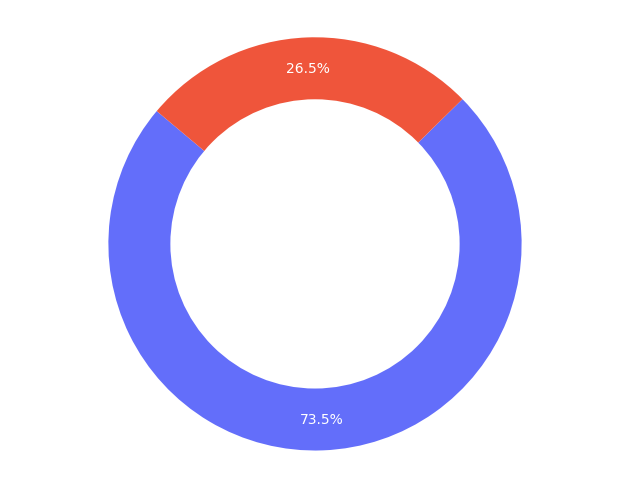

In [224]:
# Let's apply the specified color palette to the donut chart.

# Set the color palette
flatui = ["#636EFA", "#EF553B"]
sns.set_palette(flatui)

# Calculate the distribution of the 'churn' variable again
churn_distribution = churn['churn'].value_counts()

# Adjust the order of colors if necessary based on the order of churn_distribution
colors_ordered = flatui if churn_distribution.index[0] == 'No' else flatui[::-1]

# Plot with the new color palette
fig, ax = plt.subplots()
ax.pie(churn_distribution, labels=churn_distribution.index, colors=colors_ordered, startangle=140, autopct='%1.1f%%', pctdistance=0.85, textprops={'color':"w"})

# Draw a circle at the center of pie to make it look like a donut
centre_circle = plt.Circle((0,0),0.70, fc='white')
fig.gca().add_artist(centre_circle)

# Equal aspect ratio ensures that pie chart is drawn as a circle.
ax.axis('equal')  
plt.tight_layout()

# Use the style used in histograms for consistency
plt.style.use('ggplot')

# Display the plot with the new color palette
plt.show()


The vast majority of the dataset is composed of non churners, only approximately 27% are churners

Visualising distributions of variables and how do they interact with each other and churn:

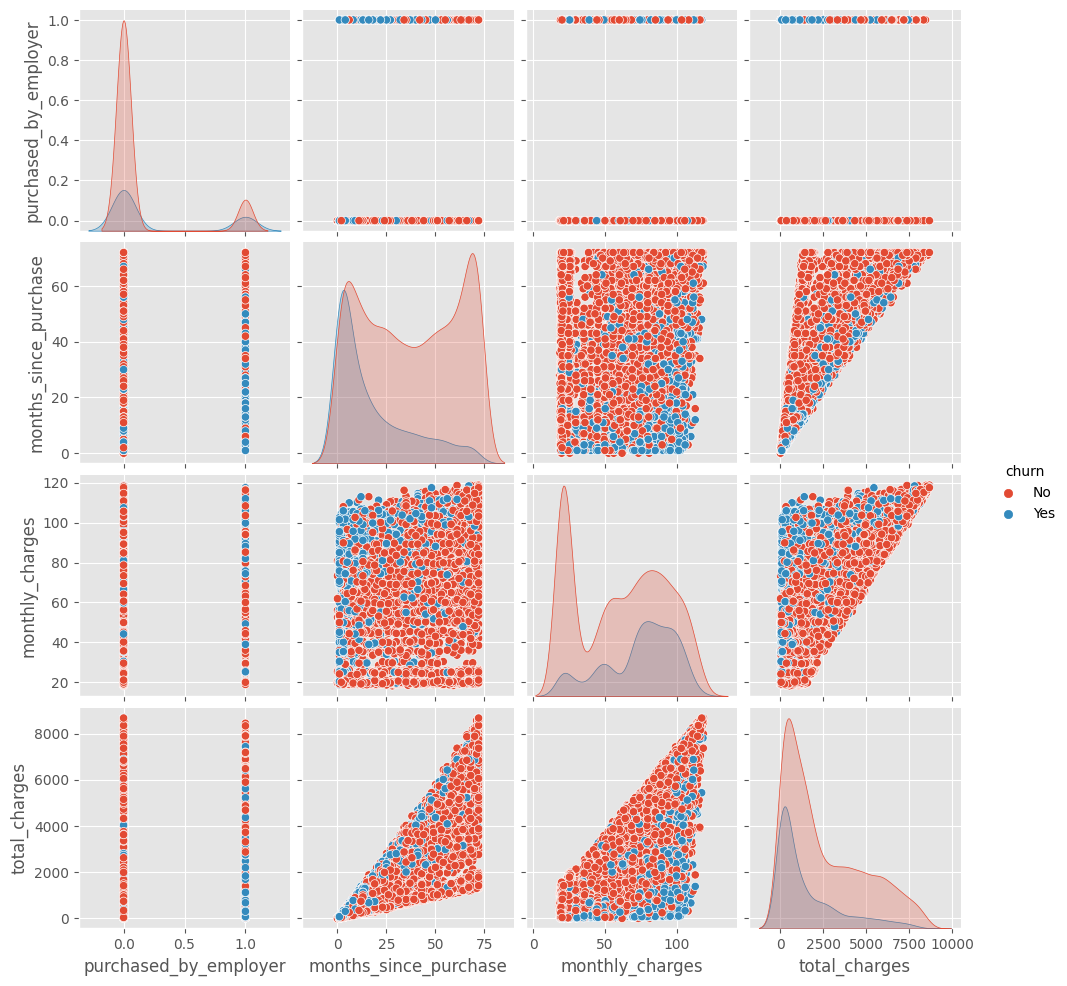

In [225]:
# Create a pair plot
sns.pairplot(churn, hue='churn', diag_kind='kde')

# Show the plot
plt.show()

There seems to be a very different behaviour for those who have churned and those who have not in regards to months since purchase - those who churn are more recent purchasers and those who did not are more loyal, older purchasers. On the intersection between total chargees and monthly charges, we can see that those who have monthly charges above 50 seem to be more likely to churn, regardless of the total amount paid.

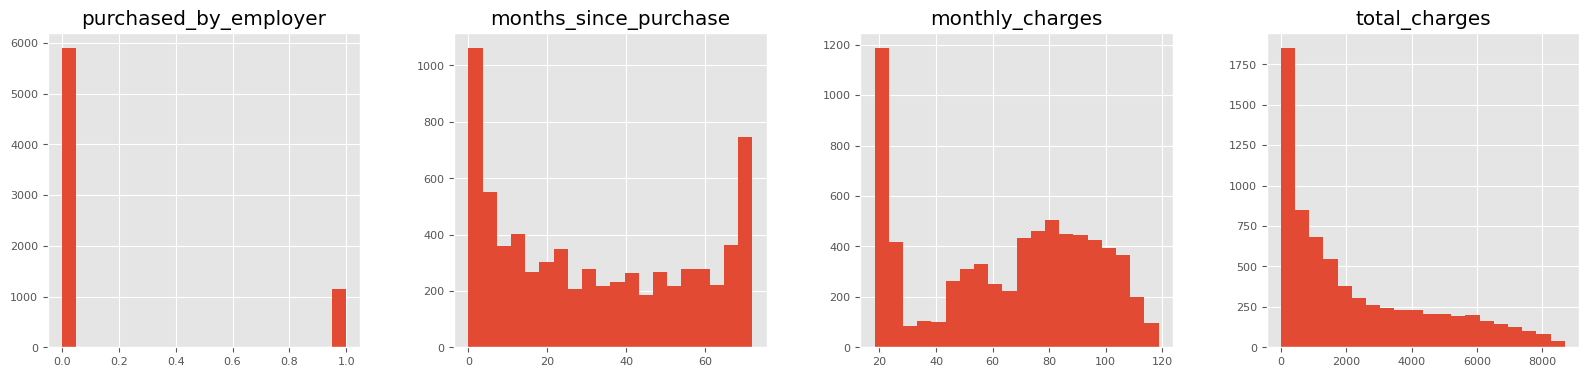

In [226]:
# Histogram representation from the variables

# Do histograms on all numeric variables
numerical=churn.select_dtypes(include=[np.number]).columns.tolist()
churn[numerical].hist(bins=20, figsize=(25, 20), layout=(4, 5), xlabelsize=8, ylabelsize=8);

- Looks like there's a long tail in regards to total charges, meaning possibly people who have been with reMarkable for a very long period of time (since the calculation here is months_since_purchase * monthly_charges) <br>
- There's two very expressive peaks in 'months_since_purchase' indicating that most people on the dataset either bought the device very recently, or either 6 years ago; <br>
- Monthly charges, oddly enough either is represented by users who pay a small few (< 30) or by those who pay a very considerable higher fee (> 70) <br>
- Purchased by employer we had already seen that it's mostly particular purchases 

/Users/diogodiogo/opt/anaconda3/lib/python3.9/site-packages/seaborn/_decorators.py:36: FutureWarning:

Pass the following variable as a keyword arg: x. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.

/Users/diogodiogo/opt/anaconda3/lib/python3.9/site-packages/seaborn/_decorators.py:36: FutureWarning:

Pass the following variable as a keyword arg: x. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.

/Users/diogodiogo/opt/anaconda3/lib/python3.9/site-packages/seaborn/_decorators.py:36: FutureWarning:

Pass the following variable as a keyword arg: x. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.

/Users/diogodiogo/opt/ana

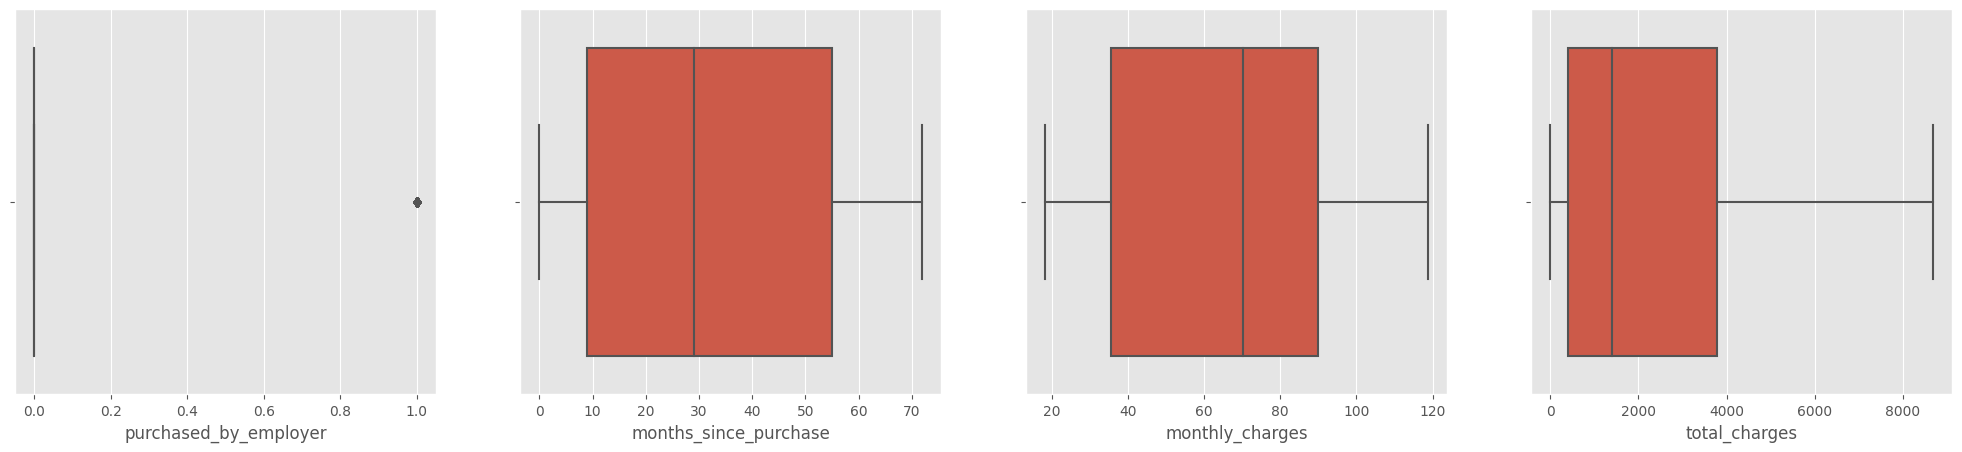

In [227]:
# Do boxplots on all numeric variables
fig, ax = plt.subplots(1,4, figsize=(25, 5))
for var, subplot in zip(churn[numerical], ax.flatten()):
    sns.boxplot(churn[var], ax=subplot)

Even though we can't see outliers in total_charges here, we have already seen on the descriptive statistics table that there is some outliers there and it looks like having the device bought by the employer is an outlier.

## Feature Engineering:

Creating user buckets based on months since purchase:

In [228]:
churn['group_first_year'] = (churn['months_since_purchase'] < 13).astype(int)
churn['group_second_year'] = ((churn['months_since_purchase'] >= 13) & (churn['months_since_purchase'] < 25)).astype(int)
churn['group_third_year'] = ((churn['months_since_purchase'] >= 13) & (churn['months_since_purchase'] < 25)).astype(int)
churn['group_more_third_year'] = (churn['months_since_purchase'] >= 37).astype(int)

Creating dummy variables:

In [229]:
# Creating dummy variables for 'payment_method' column
dummies = pd.get_dummies(churn['payment_method'], prefix='payment')

# Concatenating the dummy variables with the original 'churn' DataFrame
churn = pd.concat([churn, dummies], axis=1)

In [230]:
# Creating dummy variables for 'integration_types' column
dummies = pd.get_dummies(churn['integration_types'], prefix='integration')

# Concatenating the dummy variables with the original 'churn' DataFrame
churn = pd.concat([churn, dummies], axis=1)

In [231]:
# Creating dummy variables for 'subscription_type' column
dummies = pd.get_dummies(churn['subscription_type'], prefix='subscription')

# Concatenating the dummy variables with the original 'churn' DataFrame
churn = pd.concat([churn, dummies], axis=1)

Creating bins of monthly charges based on percentiles


In [232]:
# Creating bins of monthly charges based on percentiles
churn['monthly_charge_below_36'] = (churn['monthly_charges'] < 36).astype(int)
churn['monthly_charge_below_70'] = ((churn['monthly_charges'] >= 36) & (churn['monthly_charges'] < 70)).astype(int)
churn['monthly_charge_below_90'] = ((churn['monthly_charges'] >= 70) & (churn['monthly_charges'] < 90)).astype(int)
churn['monthly_charge_higher_90'] = (churn['monthly_charges'] >= 90).astype(int)

Creating bins of monthly charges based on percentiles

In [233]:
# Creating bins of monthly charges based on percentiles
churn['total_charge_below_399'] = (churn['total_charges'] < 399).astype(int)
churn['total_charge_below_1395'] = ((churn['total_charges'] >= 399) & (churn['total_charges'] < 1395)).astype(int)
churn['total_charge_below_3787'] = ((churn['total_charges'] >= 1395) & (churn['total_charges'] < 3787)).astype(int)
churn['total_charge_higher_3787'] = (churn['total_charges'] >= 3787).astype(int)

Creating binary variables:

In [234]:
churn['has_newest_device'] = churn['has_newest_device'].map({'Yes': 1, 'No': 0})
churn['integrations_activated'] = churn['integrations_activated'].map({'Yes': 1, 'No': 0})
churn['online_backup'] = churn['online_backup'].map({'Yes': 1, 'No': 0})
churn['device_insurance'] = churn['device_insurance'].map({'Yes': 1, 'No': 0})
churn['tech_support'] = churn['tech_support'].map({'Yes': 1, 'No': 0})
churn['recurring_payment'] = churn['recurring_payment'].map({'Yes': 1, 'No': 0})
churn['churn'] = churn['churn'].map({'Yes': 1, 'No': 0})
churn['gender'] = churn['gender'].map({'Male': 1, 'Female': 0})
churn['send_by_email'] = churn['send_by_email'].map({'Yes': 1, 'No': 0})
churn['share_screen'] = churn['share_screen'].map({'Yes': 1, 'No': 0})

Drop original variables:

In [235]:
cols_to_drop = ['integration_types', 'payment_method', 'subscription_type']
churn.drop(columns=cols_to_drop,inplace=True)
churn

customer_id  gender  purchased_by_employer  has_newest_device  \
0     7590-VHVEG       0                      0                  1   
1     5575-GNVDE       1                      0                  0   
2     3668-QPYBK       1                      0                  0   
3     7795-CFOCW       1                      0                  0   
4     9237-HQITU       0                      0                  0   
...          ...     ...                    ...                ...   
7038  6840-RESVB       1                      0                  1   
7039  2234-XADUH       0                      0                  1   
7040  4801-JZAZL       0                      0                  1   
7041  8361-LTMKD       1                      1                  1   
7042  3186-AJIEK       1                      0                  0   

      months_since_purchase  integrations_activated  online_backup  \
0                         1                       0              1   
1                        34                       1              0   
2                         2                       1              1   
3                        45                       0              0   
4                         2                       1              0   
...                     ...                     ...            ...   
7038                     24                       1              0   
7039                     72                       1              1   
7040                     11                       0              0   
7041                      4                       1              0   
7042                     66                       1              0   

      device_insurance  tech_support  send_by_email  share_screen  \
0                    0             0              0             0   
1                    1             0              0             0   
2                    0             0              0             0   
3                    1             1              0             0   
4                    0             0              0             0   
...                ...           ...            ...           ...   
7038                 1             1              1             1   
7039                 1             0              1             1   
7040                 0             0              0             0   
7041                 0             0              0             0   
7042                 1             1              1             1   

      recurring_payment  monthly_charges  total_charges  churn  \
0                     1            29.85          29.85      0   
1                     0            56.95        1889.50      0   
2                     1            53.85         108.15      1   
3                     0            42.30        1840.75      0   
4                     1            70.70         151.65      1   
...                 ...              ...            ...    ...   
7038                  1            84.80        1990.50      0   
7039                  1           103.20        7362.90      0   
7040                  1            29.60         346.45      0   
7041                  1            74.40         306.60      1   
7042                  1           105.65        6844.50      0   

      group_first_year  group_second_year  group_third_year  \
0                    1                  0                 0   
1                    0                  0                 0   
2                    1                  0                 0   
3                    0                  0                 0   
4                    1                  0                 0   
...                ...                ...               ...   
7038                 0                  1                 1   
7039                 0                  0                 0   
7040                 1                  0                 0   
7041                 1                  0                 0   
7042    

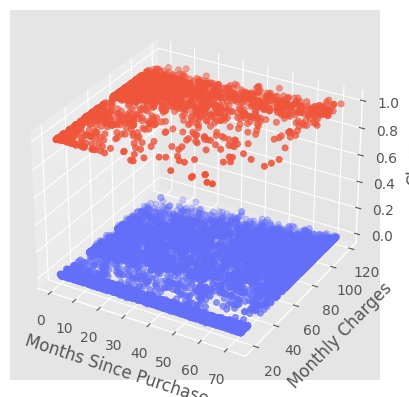

In [236]:
# Set up the figure and 3D axis
fig = plt.figure()
ax = fig.add_subplot(111, projection='3d')

# Define the color as per the flatui palette used in previous plots
# We will use the first color for 'No' and the second for 'Yes'
churn['color'] = churn['churn'].map({0: flatui[0], 1: flatui[1]})

# Plot the 3D scatter plot using the 'color' column for color coding
sc = ax.scatter(churn['months_since_purchase'], churn['monthly_charges'], churn['churn'], 
                c=churn['color'], marker='o')

# Set labels
ax.set_xlabel('Months Since Purchase')
ax.set_ylabel('Monthly Charges')
ax.set_zlabel('Churn')

# Show plot
plt.show()


It may look like there's a specific segment of users with monthly charges above 80 that seem more likely to churn

In [237]:
cols_to_drop = ['color']
churn.drop(columns=cols_to_drop,inplace=True)

There seems to be a pattern of churn when months since purchase > 20 and total charges > 80

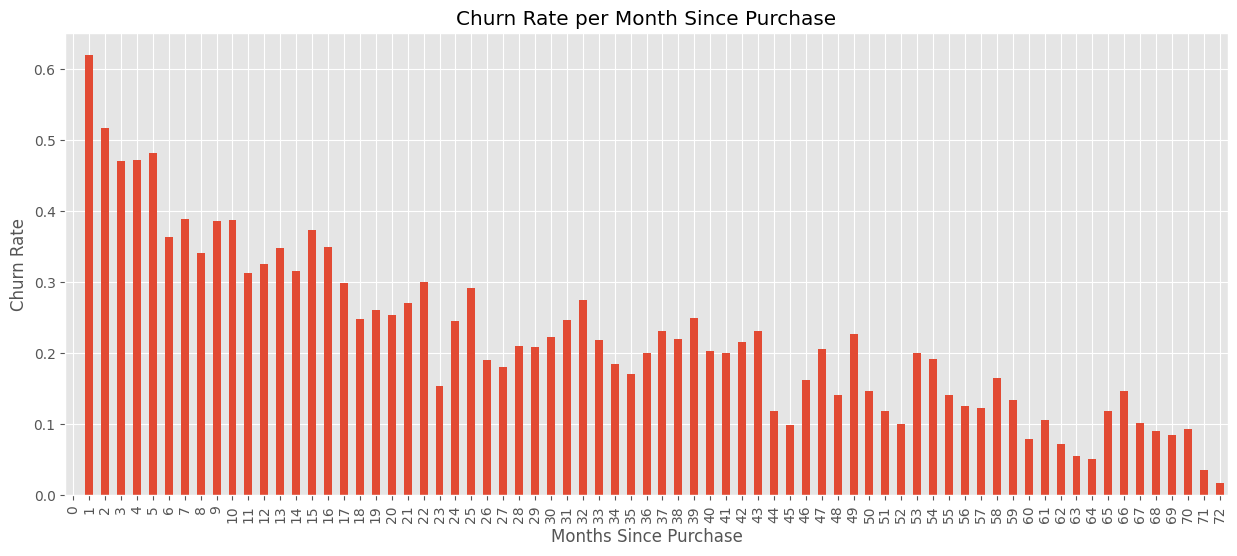

In [238]:
# Group by 'months_since_purchase' and calculate the churn rate
grouped = churn.groupby('months_since_purchase').agg(
    total_users=pd.NamedAgg(column='churn', aggfunc='size'),
    churned_users=pd.NamedAgg(column='churn', aggfunc='sum')
)
grouped['churn_rate'] = grouped['churned_users'] / grouped['total_users']

# Plotting
plt.figure(figsize=(15, 6))
grouped['churn_rate'].plot(kind='bar')
plt.xlabel('Months Since Purchase')
plt.ylabel('Churn Rate')
plt.title('Churn Rate per Month Since Purchase')
plt.show()

Users who bought the device in the first year seem more likely to churn

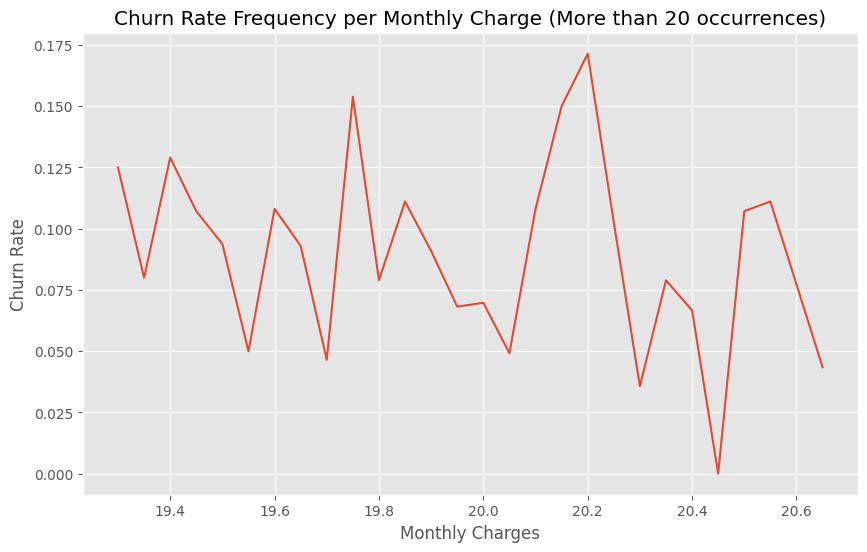

In [239]:
# Group by 'monthly_charges' and calculate the churn rate
grouped = churn.groupby('monthly_charges').agg(
    total_users=pd.NamedAgg(column='churn', aggfunc='size'),
    churned_users=pd.NamedAgg(column='churn', aggfunc='sum')
)
grouped['churn_rate'] = grouped['churned_users'] / grouped['total_users']

# Filter out groups with less than 20 occurrences
filtered_grouped = grouped[grouped['total_users'] > 20]

# Plotting
plt.figure(figsize=(10, 6))
filtered_grouped['churn_rate'].plot(kind='line')
plt.xlabel('Monthly Charges')
plt.ylabel('Churn Rate')
plt.title('Churn Rate Frequency per Monthly Charge (More than 20 occurrences)')
plt.show()

Also it seems like users with a specific monthly charge of of 19.7 and 20.2 are more liekly to churn, but their representation out of the total sample size is not significant

In [240]:
#FUNCTION FOR DOING MULTIPLE PLOTS

def plot_hist_numerical_vs_churn(column) :
    churn_customers = churn[churn['churn'] == 1 ]
    non_churn_customers = churn[churn['churn'] == 0]


    trace_non_churn = go.Histogram(x  = non_churn_customers[column],
                              name = "Non Churn Customers") 

    trace_churn = go.Histogram(x  = churn_customers[column],
                          name = "Churn customers")

    data_hist = [trace_non_churn,trace_churn]
    layout_hist = go.Layout(dict(title = column + " plotted against Customer Churn",
                            xaxis = dict(title = column),
                            yaxis = dict(title = "N"),
                           )
                       )
    fig_hist = go.Figure(data=data_hist,layout=layout_hist)
    fig_hist.show()

In [241]:
#Plot all numerical variables against churn
plot_hist_numerical_vs_churn('total_charges')
plot_hist_numerical_vs_churn('monthly_charges')
plot_hist_numerical_vs_churn('subscription_Month-to-month')
plot_hist_numerical_vs_churn('recurring_payment')
plot_hist_numerical_vs_churn('payment_Electronic check')
plot_hist_numerical_vs_churn('integration_dropbox')

Users with total charges below 1500 seem to be more likely to churn <br>;
Monthly charges between 70 to 105 seem to be more likely to churn <br>;
Subscription month to month, recurring payment, payment done through electronic check and integration with dropbox seems to have high correlation with churning

Doing a correlation matrix:

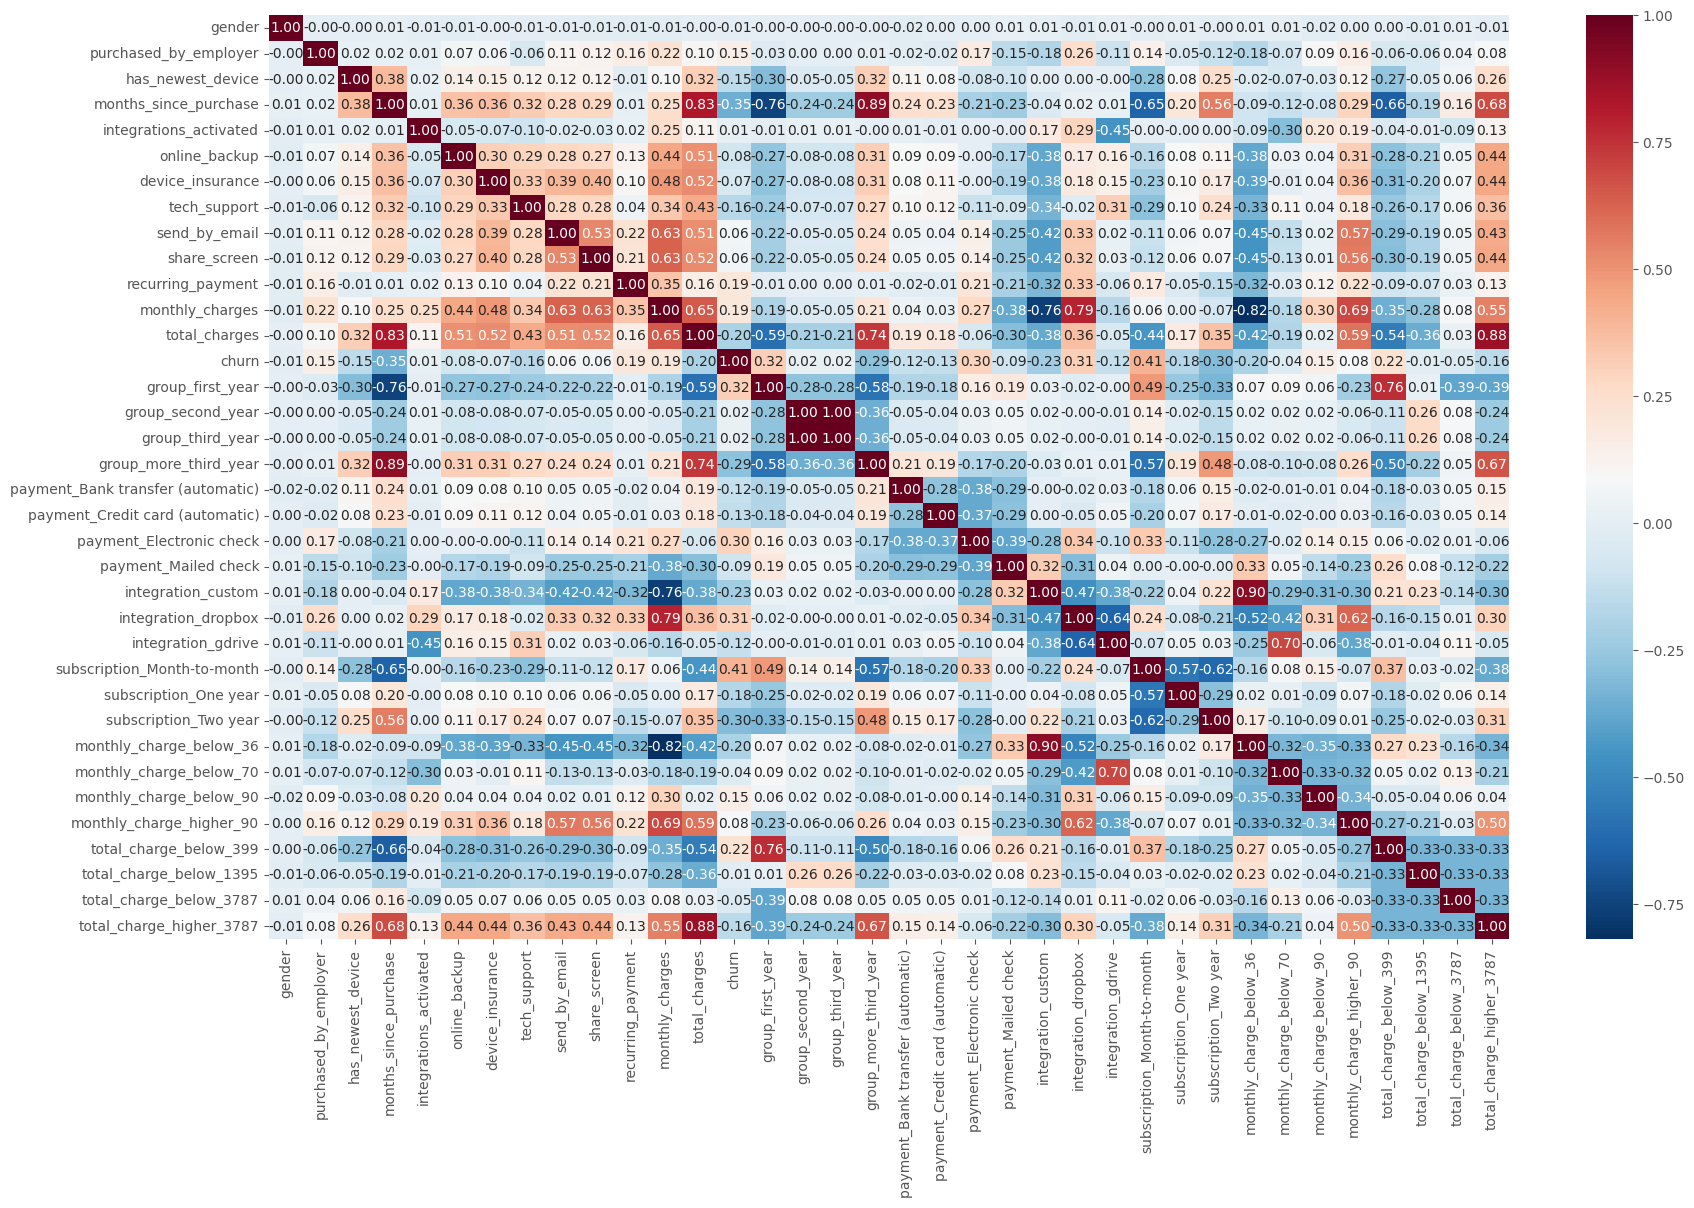

In [242]:
# Calculate the correlation matrix
correlation_matrix = churn.corr()
plt.figure(figsize=(20, 12))

# Create a heatmap using seaborn
sns.heatmap(correlation_matrix, annot=True, fmt=".2f", cmap='RdBu_r')

# Display the heatmap
plt.show()

There seems to be no evident strong variable correlated with churn

In [243]:
# Calculate the correlation matrix
correlation_matrix = churn.corr()

# Select the correlation values for the 'churn' column
correlation_with_churn = correlation_matrix['churn'].drop('churn')

significant_correlation = correlation_with_churn[correlation_with_churn > 0.3]

# Sort the correlations in descending order
sorted_correlation = significant_correlation.sort_values(ascending=False)

# Display the sorted correlation values with the dependent variable 'churn'
print(sorted_correlation)


subscription_Month-to-month    0.405103
group_first_year               0.317580
integration_dropbox            0.308020
payment_Electronic check       0.301919
Name: churn, dtype: float64


The variables that seems to affect churn the most are when users have a month to month subscription, as probably when users pay an yearly subscription they are less tempted to unsubscribe, if they have bought their device in the last 12 months, if they make their payment through electronic check and lastly if they have an integration with dropbox (a potential indicator of bugs?)

# Modelling

In [244]:
# Drop the ID
cols_to_drop = ['customer_id']
churn.drop(columns=cols_to_drop,inplace=True)

In [245]:
# Create a modeling dataset from the original dataset
X = churn.copy(deep=True)

In [246]:
# Function to plot the learning curve
# From https://scikit-learn.org/stable/auto_examples/model_selection/plot_learning_curve.html
def plot_learning_curve(estimator, title, X, y, ylim=None, cv=None,
                        n_jobs=None, train_sizes=np.linspace(.1, 1.0, 5)):
    """
    Generate a simple plot of the test and training learning curve.

    Parameters
    ----------
    estimator : object type that implements the "fit" and "predict" methods
        An object of that type which is cloned for each validation.

    title : string
        Title for the chart.

    X : array-like, shape (n_samples, n_features)
        Training vector, where n_samples is the number of samples and
        n_features is the number of features.

    y : array-like, shape (n_samples) or (n_samples, n_features), optional
        Target relative to X for classification or regression;
        None for unsupervised learning.

    ylim : tuple, shape (ymin, ymax), optional
        Defines minimum and maximum yvalues plotted.

    cv : int, cross-validation generator or an iterable, optional
        Determines the cross-validation splitting strategy.
        Possible inputs for cv are:
          - None, to use the default 3-fold cross-validation,
          - integer, to specify the number of folds.
          - :term:`CV splitter`,
          - An iterable yielding (train, test) splits as arrays of indices.

        For integer/None inputs, if ``y`` is binary or multiclass,
        :class:`StratifiedKFold` used. If the estimator is not a classifier
        or if ``y`` is neither binary nor multiclass, :class:`KFold` is used.

        Refer :ref:`User Guide <cross_validation>` for the various
        cross-validators that can be used here.

    n_jobs : int or None, optional (default=None)
        Number of jobs to run in parallel.
        ``None`` means 1 unless in a :obj:`joblib.parallel_backend` context.
        ``-1`` means using all processors. See :term:`Glossary <n_jobs>`
        for more details.

    train_sizes : array-like, shape (n_ticks,), dtype float or int
        Relative or absolute numbers of training examples that will be used to
        generate the learning curve. If the dtype is float, it is regarded as a
        fraction of the maximum size of the training set (that is determined
        by the selected validation method), i.e. it has to be within (0, 1].
        Otherwise it is interpreted as absolute sizes of the training sets.
        Note that for classification the number of samples usually have to
        be big enough to contain at least one sample from each class.
        (default: np.linspace(0.1, 1.0, 5))
    """
    plt.figure()
    plt.title(title)
    if ylim is not None:
        plt.ylim(*ylim)
    plt.xlabel("Training examples")
    plt.ylabel("Score")
    train_sizes, train_scores, test_scores = learning_curve(
        estimator, X, y, cv=cv, n_jobs=n_jobs, train_sizes=train_sizes)
    train_scores_mean = np.mean(train_scores, axis=1)
    train_scores_std = np.std(train_scores, axis=1)
    test_scores_mean = np.mean(test_scores, axis=1)
    test_scores_std = np.std(test_scores, axis=1)
    plt.grid()

    plt.fill_between(train_sizes, train_scores_mean - train_scores_std,
                     train_scores_mean + train_scores_std, alpha=0.1,
                     color="r")
    plt.fill_between(train_sizes, test_scores_mean - test_scores_std,
                     test_scores_mean + test_scores_std, alpha=0.1, color="g")
    plt.plot(train_sizes, train_scores_mean, 'o-', color="r",
             label="Training score")
    plt.plot(train_sizes, test_scores_mean, 'o-', color="g",
             label="Cross-validation score")

    plt.legend(loc="best")
    return plt

In [247]:
# Function to calculate MAPE metric
def mean_absolute_percentage_error(y_true, y_pred): 
    y_true, y_pred = np.array(y_true), np.array(y_pred)
    return np.mean(np.abs((y_true - y_pred) / y_true)) * 100

In [248]:
# Function to create dataframe with metrics
def performanceMetricsDF(metricsObj, yTrain, yPredTrain, yTest, yPredTest):
  measures_list = ['MAE','RMSE', 'R^2','MAPE (%)','MAX Error']
  train_results = [metricsObj.mean_absolute_error(yTrain, yPredTrain),
                np.sqrt(metricsObj.mean_squared_error(yTrain, yPredTrain)),
                metricsObj.r2_score(yTrain, yPredTrain),
                mean_absolute_percentage_error(yTrain, yPredTrain),
                metricsObj.max_error(yTrain, yPredTrain)]
  test_results = [metricsObj.mean_absolute_error(yTest, yPredTest),
                np.sqrt(metricsObj.mean_squared_error(yTest, yPredTest)),
                metricsObj.r2_score(yTest, yPredTest),
                  mean_absolute_percentage_error(yTest, yPredTest),
                metricsObj.max_error(yTest, yPredTest)]
  resultsDF = pd.DataFrame({'Measure': measures_list, 'Train': train_results, 'Test':test_results})
  return(resultsDF)

In [249]:
# Function to plot confusion matrix - Adapted from https://github.com/DTrimarchi10/confusion_matrix/blob/master/cf_matrix.py
def make_confusion_matrix(cf,
                          group_names=None,
                          categories='auto',
                          count=True,
                          percent=True,
                          cbar=True,
                          xyticks=True,
                          xyplotlabels=True,
                          sum_stats=True,
                          figsize=None,
                          cmap='Blues',
                          title=None):
    '''
    This function will make a pretty plot of an sklearn Confusion Matrix cm using a Seaborn heatmap visualization.
    Arguments
    ---------
    cf:            confusion matrix to be passed in
    group_names:   List of strings that represent the labels row by row to be shown in each square.
    categories:    List of strings containing the categories to be displayed on the x,y axis. Default is 'auto'
    count:         If True, show the raw number in the confusion matrix. Default is True.
    normalize:     If True, show the proportions for each category. Default is True.
    cbar:          If True, show the color bar. The cbar values are based off the values in the confusion matrix.
                   Default is True.
    xyticks:       If True, show x and y ticks. Default is True.
    xyplotlabels:  If True, show 'True Label' and 'Predicted Label' on the figure. Default is True.
    sum_stats:     If True, display summary statistics below the figure. Default is True.
    figsize:       Tuple representing the figure size. Default will be the matplotlib rcParams value.
    cmap:          Colormap of the values displayed from matplotlib.pyplot.cm. Default is 'Blues'
                   See http://matplotlib.org/examples/color/colormaps_reference.html
                   
    title:         Title for the heatmap. Default is None.
    '''


    # CODE TO GENERATE TEXT INSIDE EACH SQUARE
    blanks = ['' for i in range(cf.size)]

    if group_names and len(group_names)==cf.size:
        group_labels = ["{}\n".format(value) for value in group_names]
    else:
        group_labels = blanks

    if count:
        group_counts = ["{0:0.0f}\n".format(value) for value in cf.flatten()]
    else:
        group_counts = blanks

    if percent:
        group_percentages = ["{0:.2%}".format(value) for value in cf.flatten()/np.sum(cf)]
    else:
        group_percentages = blanks

    box_labels = [f"{v1}{v2}{v3}".strip() for v1, v2, v3 in zip(group_labels,group_counts,group_percentages)]
    box_labels = np.asarray(box_labels).reshape(cf.shape[0],cf.shape[1])


    # CODE TO GENERATE SUMMARY STATISTICS & TEXT FOR SUMMARY STATS
    if sum_stats:
        #Accuracy is sum of diagonal divided by total observations
        accuracy  = np.trace(cf) / float(np.sum(cf))

        #if it is a binary confusion matrix, show some more stats
        if len(cf)==2:
            #Metrics for Binary Confusion Matrices
            precision = cf[1,1] / sum(cf[:,1])
            recall    = cf[1,1] / sum(cf[1,:])
            f1_score  = 2*precision*recall / (precision + recall)
            stats_text = "\n\nAccuracy={:0.3f}\nPrecision={:0.3f}\nRecall={:0.3f}\nF1 Score={:0.3f}".format(
                accuracy,precision,recall,f1_score)
        else:
            stats_text = "\n\nAccuracy={:0.3f}".format(accuracy)
    else:
        stats_text = ""


    # SET FIGURE PARAMETERS ACCORDING TO OTHER ARGUMENTS
    if figsize==None:
        #Get default figure size if not set
        figsize = plt.rcParams.get('figure.figsize')

    if xyticks==False:
        #Do not show categories if xyticks is False
        categories=False


    # MAKE THE HEATMAP VISUALIZATION
    plt.figure(figsize=figsize)
    ax = sns.heatmap(cf,annot=box_labels, fmt="",cmap=cmap,cbar=cbar,xticklabels=categories,yticklabels=categories)
    bottom, top = ax.get_ylim() # These two lines were added due to bug on current Seaborn version
    ax.set_ylim(bottom + 0.5, top - 0.5) #

    if xyplotlabels:
        plt.ylabel('True label')
        plt.xlabel('Predicted label' + stats_text)
    else:
        plt.xlabel(stats_text)
    
    if title:
        plt.title(title)

In [250]:
# Display the evaluation metrics side by side 
def display_side_by_side(dfs:list, captions:list):
    """Display tables side by side to save vertical space
    Input:
        dfs: list of pandas.DataFrame
        captions: list of table captions
    """
    output = ""
    combined = dict(zip(captions, dfs))
    for caption, df in combined.items():
        output += df.style.set_table_attributes("style='display:inline'").set_caption(caption).repr_html()
        output += "\xa0\xa0\xa0"
    display(HTML(output))

## Model Preparation

In [251]:
#Copy of the dataframe for the algorithms without normalization need (Decision Tree / Random Forest)
D = X.copy(deep=True)

In [252]:
# Create the target
y = D['churn']

In [253]:
#Data Partition with 75% for Training and 25% for Testing
X_trainD, X_testD, y_trainD, y_testD = train_test_split(D, y, test_size=0.25, stratify=y, random_state=123)

In [254]:
# Remove the Target from the training
X_trainD = X_trainD.drop(['churn'],1)
X_testD = X_testD.drop(['churn'],1)

/var/folders/7g/q_2j27sx0031sv8_qdf0n5000000gn/T/ipykernel_1818/838846245.py:2: FutureWarning:

In a future version of pandas all arguments of DataFrame.drop except for the argument 'labels' will be keyword-only.

/var/folders/7g/q_2j27sx0031sv8_qdf0n5000000gn/T/ipykernel_1818/838846245.py:3: FutureWarning:

In a future version of pandas all arguments of DataFrame.drop except for the argument 'labels' will be keyword-only.



In [255]:
# Dropping the Target Variable from the Dataset
D = D.drop(['churn'],1)

/var/folders/7g/q_2j27sx0031sv8_qdf0n5000000gn/T/ipykernel_1818/290402611.py:2: FutureWarning:

In a future version of pandas all arguments of DataFrame.drop except for the argument 'labels' will be keyword-only.



Counter({0: 3880, 1: 1402})
0    0.73457
1    0.26543
Name: churn, dtype: float64


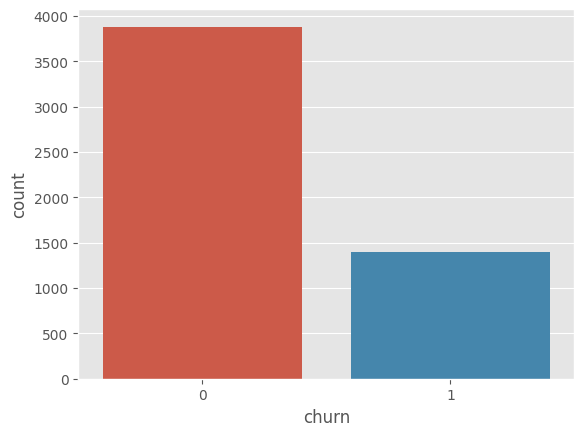

In [256]:
# Display target balance in the training dataset
print(collections.Counter(y_trainD))
sns.countplot(x="churn", data=pd.DataFrame(data={'churn':y_trainD}))
print(y_trainD.value_counts(normalize=True))

Counter({0: 3880, 1: 3880})


<Axes: xlabel='churn', ylabel='count'>

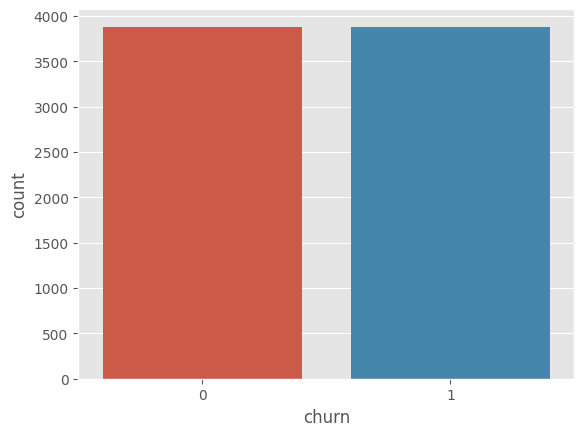

In [257]:
# Applyting SMOTE to generare new instances (oversampling)
sm = SMOTE(random_state=123, sampling_strategy=1.0)
X_train_scaled_D, y_train_scaled_D = sm.fit_resample(X_trainD, y_trainD)

# Display target balance in the training dataset
print(collections.Counter(y_train_scaled_D))
sns.countplot(x="churn", data=pd.DataFrame(data={'churn':y_train_scaled_D}))

Algorithms with Normalization

In [258]:
#Copy of the dataframe for the algorithms with normalization need - Regressions
R = X.copy(deep=True)

In [259]:
# Associating the dataframe with the target variable
y = R['churn']

In [260]:
# Split into train and test (75% train and 25% test)
X_train, X_test, y_train, y_test = train_test_split(R, y, test_size=0.25, stratify=y, random_state=123)

In [261]:
# Remove the Target from the training
X_train = X_train.drop(['churn'],1)
X_test = X_test.drop(['churn'],1)

/var/folders/7g/q_2j27sx0031sv8_qdf0n5000000gn/T/ipykernel_1818/1888249836.py:2: FutureWarning:

In a future version of pandas all arguments of DataFrame.drop except for the argument 'labels' will be keyword-only.

/var/folders/7g/q_2j27sx0031sv8_qdf0n5000000gn/T/ipykernel_1818/1888249836.py:3: FutureWarning:

In a future version of pandas all arguments of DataFrame.drop except for the argument 'labels' will be keyword-only.



In [262]:
# Dataframe for scaling
tempDF = X.copy(deep=True)
tempDF.drop(columns='churn', inplace=True)

# Normalize training/test data
scaler = MinMaxScaler(feature_range=(0, 1))
tempDF_scaled = scaler.fit_transform(tempDF)
X_train_scaled = scaler.transform(X_train)
X_test_scaled = scaler.transform(X_test)

In [263]:
# Applyting SMOTE to generare new instances (oversampling)
sm = SMOTE(random_state=123, sampling_strategy=1.0)
X_train_scaled2, y_train2 = sm.fit_resample(X_train_scaled, y_train)

Linear Regression

In [264]:
# Create and train the model  Linear regression 
lr_regr = linear_model.LinearRegression()
lr_regr.fit(X_train_scaled, y_train)

LinearRegression()

<module 'matplotlib.pyplot' from '/Users/diogodiogo/opt/anaconda3/lib/python3.9/site-packages/matplotlib/pyplot.py'>

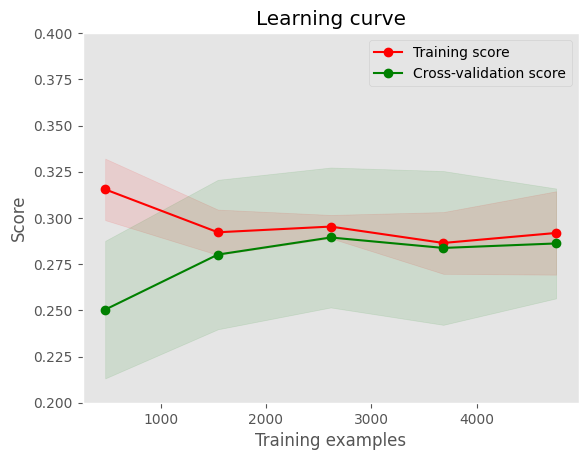

In [265]:
# Plot the learning curve

# Cross validation division of 5 or 10 folds
cv = 10
estimator = linear_model.LinearRegression()
plot_learning_curve(estimator, "Learning curve", X_train_scaled, y_train, ylim=(0.2, 0.4), cv=cv, n_jobs=4,
                   train_sizes=np.linspace(0.1, 1.0, 5))

In [266]:
# Print the Intercept
print('Intercept:',lr_regr.intercept_, '\n')

# Print Coefficients by descending "importance"
formattedList = [format(float(i),'.6f') for i in lr_regr.coef_]
formattedList2 = [format(abs(float(i)),'.6f') for i in lr_regr.coef_]
data_tuples = list(zip(X.columns,formattedList,formattedList2))
coeff_df = pd.DataFrame(data=data_tuples, columns=['Feature','Coefficient','AbsCoefficient'])
coeff_df['AbsCoefficient']=coeff_df['AbsCoefficient'].astype(float)
coeff_df.sort_values('AbsCoefficient', axis=0, inplace=True, ascending=False)
coeff_df

Intercept: 10220989081474.441 



Feature            Coefficient  AbsCoefficient
18  payment_Bank transfer (automatic)  -8985947661519.429688    8.985948e+12
20           payment_Electronic check  -8985947661519.414062    8.985948e+12
17              group_more_third_year  -8985947661519.396484    8.985948e+12
19    payment_Credit card (automatic)  -8985947661519.339844    8.985948e+12
24                 integration_gdrive   7064127703510.994141    7.064128e+12
26              subscription_One year   7064127703510.905273    7.064128e+12
25        subscription_Month-to-month   7064127703510.889648    7.064128e+12
21               payment_Mailed check  -5858367692270.256836    5.858368e+12
23                integration_dropbox  -5858367692269.775391    5.858368e+12
22                 integration_custom  -5858367692269.331055    5.858368e+12
28            monthly_charge_below_36  -4865366570575.504883    4.865367e+12
27              subscription_Two year  -4865366570575.484375    4.865367e+12
30            monthly_charge_below_90  -4865366570575.429688    4.865367e+12
29            monthly_charge_below_70  -4865366570575.426758    4.865367e+12
31           monthly_charge_higher_90   2424565139379.739746    2.424565e+12
32             total_charge_below_399   2424565139379.550781    2.424565e+12
33            total_charge_below_1395   2424565139379.468262    2.424565e+12
34            total_charge_below_3787   2424565139379.443848    2.424565e+12
14                   group_first_year   -763614420215.344360    7.636144e+11
15                  group_second_year    763614420215.262695    7.636144e+11
11                    monthly_charges              -1.076161    1.076161e+00
12                      total_charges              -0.619148    6.191480e-01
4              integrations_activated               0.295045    2.950450e-01
9                        share_screen               0.196974    1.969740e-01
8                       send_by_email               0.175478    1.754780e-01
13                              churn              -0.093728    9.372800e-02
6                    device_insurance               0.080499    8.049900e-02
16                   group_third_year               0.073279    7.327900e-02
1               purchased_by_employer               0.067319    6.731900e-02
10                  recurring_payment               0.061456    6.145600e-02
3               months_since_purchase               0.059750    5.975000e-02
5                       online_backup               0.038871    3.887100e-02
7                        tech_support               0.033628    3.362800e-02
2                   has_newest_device              -0.021595    2.159500e-02
0                              gender               0.000023    2.300000e-05

In [267]:
# predict y for X_train and X_test
y_pred_train = lr_regr.predict(X_train_scaled) 
y_pred_test = lr_regr.predict(X_test_scaled) 

In [268]:
# Show performance results
resultsDF = performanceMetricsDF(metrics, y_train, y_pred_train, y_test, y_pred_test)
resultsDF

/var/folders/7g/q_2j27sx0031sv8_qdf0n5000000gn/T/ipykernel_1818/4175523280.py:4: RuntimeWarning:

divide by zero encountered in true_divide

/var/folders/7g/q_2j27sx0031sv8_qdf0n5000000gn/T/ipykernel_1818/4175523280.py:4: RuntimeWarning:

invalid value encountered in true_divide

/var/folders/7g/q_2j27sx0031sv8_qdf0n5000000gn/T/ipykernel_1818/4175523280.py:4: RuntimeWarning:

divide by zero encountered in true_divide

/var/folders/7g/q_2j27sx0031sv8_qdf0n5000000gn/T/ipykernel_1818/4175523280.py:4: RuntimeWarning:

invalid value encountered in true_divide



Measure     Train      Test
0        MAE  0.291138  0.299467
1       RMSE  0.372229  0.383424
2        R^2  0.289378  0.245559
3   MAPE (%)       NaN       NaN
4  MAX Error  1.109375  1.244141

R squared which tells how much the model is able to explain the variability in the dependent variable 'churn' is quite low in this model: 30%

## Logistic Regression

In [269]:
# Create object and train the model
lrModel = LogisticRegression(random_state=123)
lrModel.fit(X_train_scaled2, y_train2)

/Users/diogodiogo/opt/anaconda3/lib/python3.9/site-packages/sklearn/linear_model/_logistic.py:458: ConvergenceWarning:

lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression



LogisticRegression(random_state=123)

In [270]:
# Predict values
# predict y for X_train and X_test
y_pred_train = lrModel.predict(X_train_scaled2) 
y_pred_test = lrModel.predict(X_test_scaled) 

In [271]:
# Show 10 top features coefficients
abs_coef = np.concatenate(np.abs(lrModel.coef_))
sorted_index = np.argsort(abs_coef)[::-1] # sort indices
top_10 = sorted_index[:10]
top_10DF = pd.DataFrame(data={'feature': list(X_train.columns[top_10]), 'coef': abs_coef[top_10]})
top_10DF

feature      coef
0        months_since_purchase  2.941768
1                total_charges  1.509105
2        subscription_Two year  0.970736
3  subscription_Month-to-month  0.898347
4        group_more_third_year  0.892100
5          integration_dropbox  0.792044
6       total_charge_below_399  0.735607
7     total_charge_higher_3787  0.690147
8           integration_custom  0.653611
9              monthly_charges  0.578407

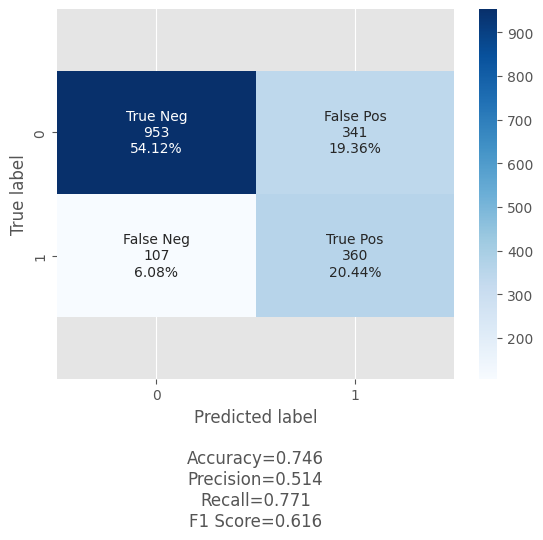

In [272]:
# Show the confusion matrix
cf = metrics.confusion_matrix(y_test,y_pred_test)
labels = ['True Neg','False Pos','False Neg','True Pos']
categories = ['0', '1']
make_confusion_matrix(cf, 
                      group_names=labels,
                      categories=categories, 
                      cmap='Blues')
LogisticRegression_ConfMatrix = cf

In [273]:
# Show performance results
resultsDF = performanceMetricsDF(metrics, y_train2, y_pred_train, y_test, y_pred_test)

LogisticRegression_Metrics = resultsDF

resultsDF

/var/folders/7g/q_2j27sx0031sv8_qdf0n5000000gn/T/ipykernel_1818/4175523280.py:4: RuntimeWarning:

divide by zero encountered in true_divide

/var/folders/7g/q_2j27sx0031sv8_qdf0n5000000gn/T/ipykernel_1818/4175523280.py:4: RuntimeWarning:

invalid value encountered in true_divide

/var/folders/7g/q_2j27sx0031sv8_qdf0n5000000gn/T/ipykernel_1818/4175523280.py:4: RuntimeWarning:

divide by zero encountered in true_divide

/var/folders/7g/q_2j27sx0031sv8_qdf0n5000000gn/T/ipykernel_1818/4175523280.py:4: RuntimeWarning:

invalid value encountered in true_divide



Measure     Train      Test
0        MAE  0.223969  0.254401
1       RMSE  0.473254  0.504382
2        R^2  0.104124 -0.305528
3   MAPE (%)       NaN       NaN
4  MAX Error  1.000000  1.000000

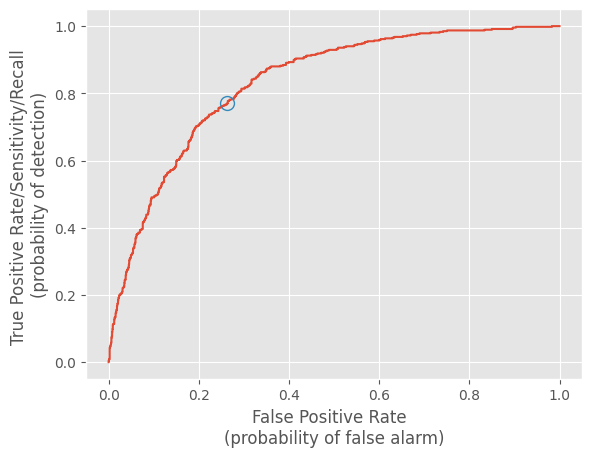

AUC:0.8312239987555808


In [274]:
# ROC curve
FP,TP,thresholds = metrics.roc_curve(y_test,lrModel.decision_function(X_test_scaled))
plt.plot(FP,TP,label="ROC")
plt.xlabel("False Positive Rate  \n(probability of false alarm)")
plt.ylabel("True Positive Rate/Sensitivity/Recall \n(probability of detection)")
cutoff=np.argmin(np.abs(thresholds)) # minimize FP, to maximize TP
plt.plot(FP[cutoff],TP[cutoff],'o',markersize=10,label="cutoff",fillstyle="none")
plt.show()
print("AUC:{}".format(metrics.auc(FP, TP))) # AUC of ROC

Even though the model has a low r squared (10%), the model has a high recall which is the metric most important in this analysis and an AUC above 80% which is an indicator of a great model.

## Decision Tree

In [275]:
#Grid Search for parameter finetuning:
grid_param = [{'max_depth':[3, 4, 5, 6, 7, 9,10,11,12,13,15,20,35,50],
          'min_samples_leaf':[2,3,4,5,7,10,50,100],        
          'random_state':[123]}]
classModel = tree.DecisionTreeClassifier(random_state=123)
grid = GridSearchCV(classModel, grid_param, cv=5) #5 fold cross validation (5 folds each of the combinations) 
grid.fit(X_train_scaled_D, y_train_scaled_D)
print("Grid search best parameters: {}".format(grid.best_params_))

Grid search best parameters: {'max_depth': 7, 'min_samples_leaf': 7, 'random_state': 123}


In [276]:
# Create object and train the model
decisionTreeModel = tree.DecisionTreeClassifier(**grid.best_params_)
decisionTreeModel.fit(X_train_scaled_D, y_train_scaled_D)

DecisionTreeClassifier(max_depth=7, min_samples_leaf=7, random_state=123)

In [277]:
# predict y for X_train and X_test
y_pred_trainD = decisionTreeModel.predict(X_train_scaled_D) 
y_pred_testD = decisionTreeModel.predict(X_testD) 

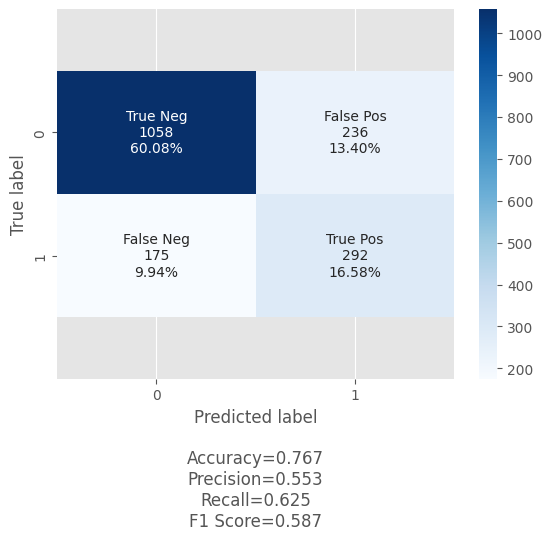

In [278]:
# Show the confusion matrix
cf = metrics.confusion_matrix(y_testD,y_pred_testD)
labels = ['True Neg','False Pos','False Neg','True Pos']
categories = ['0', '1']
make_confusion_matrix(cf, 
                      group_names=labels,
                      categories=categories, 
                      cmap='Blues')
DecisionTree_ConfMatrix = cf

In [279]:
resultsDF = performanceMetricsDF(metrics, y_train_scaled_D, y_pred_trainD, y_testD, y_pred_testD)

DecisionTree_Metrics = resultsDF

resultsDF

/var/folders/7g/q_2j27sx0031sv8_qdf0n5000000gn/T/ipykernel_1818/4175523280.py:4: RuntimeWarning:

divide by zero encountered in true_divide

/var/folders/7g/q_2j27sx0031sv8_qdf0n5000000gn/T/ipykernel_1818/4175523280.py:4: RuntimeWarning:

invalid value encountered in true_divide

/var/folders/7g/q_2j27sx0031sv8_qdf0n5000000gn/T/ipykernel_1818/4175523280.py:4: RuntimeWarning:

divide by zero encountered in true_divide

/var/folders/7g/q_2j27sx0031sv8_qdf0n5000000gn/T/ipykernel_1818/4175523280.py:4: RuntimeWarning:

invalid value encountered in true_divide



Measure     Train      Test
0        MAE  0.150129  0.233390
1       RMSE  0.387465  0.483105
2        R^2  0.399485 -0.197705
3   MAPE (%)       NaN       NaN
4  MAX Error  1.000000  1.000000

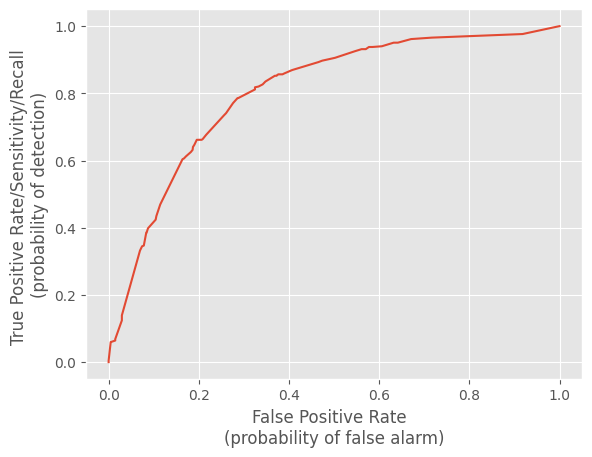

AUC:0.804
Optimal threshold:0.351


In [280]:
# ROC curve
probs = decisionTreeModel.predict_proba(X_testD)
FP,TP,thresholds = metrics.roc_curve(y_testD,probs[:,1])
plt.plot(FP,TP,label="ROC")
plt.xlabel("False Positive Rate  \n(probability of false alarm)")
plt.ylabel("True Positive Rate/Sensitivity/Recall \n(probability of detection)")
cutoff=np.argmax(np.abs(TP-FP)) 
optimal_threshold = thresholds[cutoff]
plt.show()
print("AUC:{0:.3f}".format(metrics.auc(FP, TP)))
print("Optimal threshold:{0:.3f}".format(optimal_threshold))

In [281]:
# Get feature importance
importance = list(decisionTreeModel.feature_importances_)
# Create tuples with variable and value
feature_importance = [(feature, round(importance, 2)) for feature, importance in zip(list(D.columns), importance)]
# Sort in descend order
feature_importance = sorted(feature_importance, key = lambda D: D[1], reverse = True)
resultsDF = pd.DataFrame(data=feature_importance, columns=['Feature', 'Importance'])
resultsDF

Feature  Importance
0         subscription_Month-to-month        0.34
1               subscription_One year        0.18
2               months_since_purchase        0.09
3                 integration_dropbox        0.06
4               subscription_Two year        0.06
5            payment_Electronic check        0.05
6                       total_charges        0.04
7                     monthly_charges        0.03
8   payment_Bank transfer (automatic)        0.03
9     payment_Credit card (automatic)        0.03
10                       tech_support        0.02
11               payment_Mailed check        0.02
12                             gender        0.01
13                 integration_custom        0.01
14              purchased_by_employer        0.00
15                  has_newest_device        0.00
16             integrations_activated        0.00
17                      online_backup        0.00
18                   device_insurance        0.00
19                      send_by_email        0.00
20                       share_screen        0.00
21                  recurring_payment        0.00
22                   group_first_year        0.00
23                  group_second_year        0.00
24                   group_third_year        0.00
25              group_more_third_year        0.00
26                 integration_gdrive        0.00
27            monthly_charge_below_36        0.00
28            monthly_charge_below_70        0.00
29            monthly_charge_below_90        0.00
30           monthly_charge_higher_90        0.00
31             total_charge_below_399        0.00
32            total_charge_below_1395        0.00
33            total_charge_below_3787        0.00
34           total_charge_higher_3787        0.00

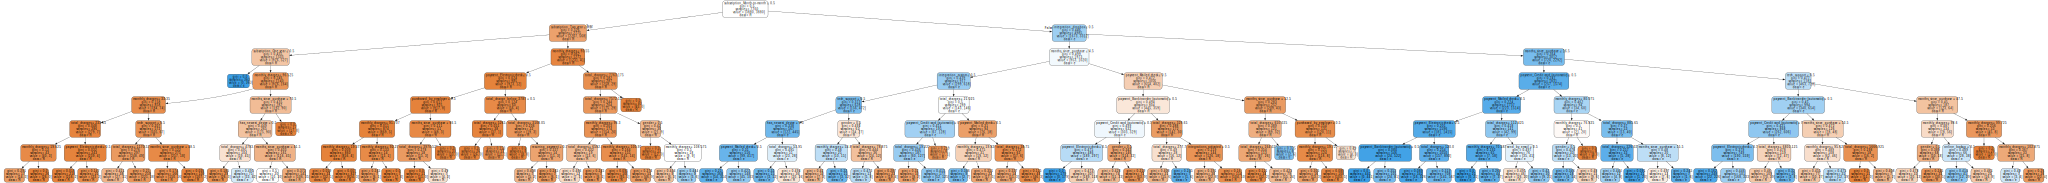

In [282]:
# Plot the tree
dot_data = tree.export_graphviz(decisionTreeModel, out_file=None, 
                      feature_names=list(X_trainD.columns),  
                      class_names='Returns',  
                      filled=True, rounded=True,  
                      special_characters=True)  
graph = graphviz.Source(dot_data)  
graph 

Decision trees seems to be a model that is overfitting since the difference in R Squared is so significant. The recall is also quite low.

## Random Forest

In [283]:
# Execute Grid Search to hyper tune parameters
#For list of partameters check https://scikit-learn.org/stable/modules/generated/sklearn.neural_network.MLPRegressor.html
grid_param = [{'n_estimators': [100,200,250,300],
          'max_depth':[5,10,20,25,30],
          'min_samples_leaf':[5,10],
          'random_state':[123]}]
randomForestModel = RandomForestClassifier()
grid = GridSearchCV(randomForestModel, grid_param, cv=5)
grid.fit(X_train_scaled_D, y_train_scaled_D)
print("Grid search best parameters: {}".format(grid.best_params_))

Grid search best parameters: {'max_depth': 25, 'min_samples_leaf': 5, 'n_estimators': 200, 'random_state': 123}


In [284]:
#Create object and train the model
randomForestModel = RandomForestClassifier(**grid.best_params_)
randomForestModel.fit(X_train_scaled_D, y_train_scaled_D)

RandomForestClassifier(max_depth=25, min_samples_leaf=5, n_estimators=200,
                       random_state=123)

In [285]:
# predict y for X_train and X_test
y_pred_trainF = randomForestModel.predict(X_train_scaled_D) 
y_pred_testF = randomForestModel.predict(X_testD) 

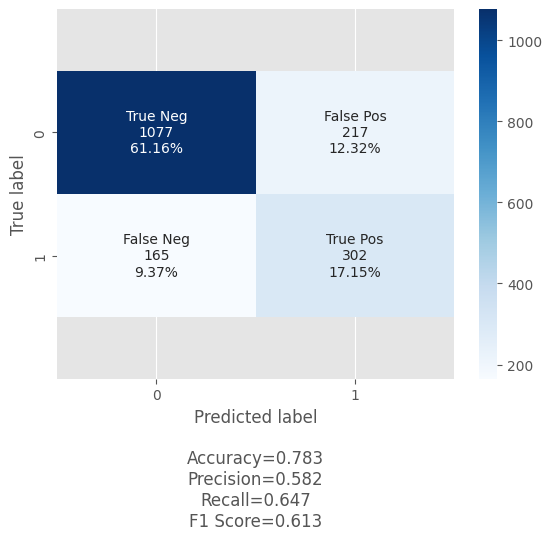

In [286]:
# Show the confusion matrix
cf = metrics.confusion_matrix(y_testD,y_pred_testF)
labels = ['True Neg','False Pos','False Neg','True Pos']
categories = ['0', '1']
make_confusion_matrix(cf, 
                      group_names=labels,
                      categories=categories, 
                     cmap='Blues')
RandomForest_ConfMatrix = cf

In [287]:
resultsDF = performanceMetricsDF(metrics, y_train_scaled_D, y_pred_trainF, y_testD, y_pred_testF)

RandomForest_Metrics = resultsDF

resultsDF

/var/folders/7g/q_2j27sx0031sv8_qdf0n5000000gn/T/ipykernel_1818/4175523280.py:4: RuntimeWarning:

divide by zero encountered in true_divide

/var/folders/7g/q_2j27sx0031sv8_qdf0n5000000gn/T/ipykernel_1818/4175523280.py:4: RuntimeWarning:

invalid value encountered in true_divide

/var/folders/7g/q_2j27sx0031sv8_qdf0n5000000gn/T/ipykernel_1818/4175523280.py:4: RuntimeWarning:

divide by zero encountered in true_divide

/var/folders/7g/q_2j27sx0031sv8_qdf0n5000000gn/T/ipykernel_1818/4175523280.py:4: RuntimeWarning:

invalid value encountered in true_divide



Measure     Train      Test
0        MAE  0.110052  0.216922
1       RMSE  0.331740  0.465749
2        R^2  0.559794 -0.113196
3   MAPE (%)       NaN       NaN
4  MAX Error  1.000000  1.000000

56% Train R2

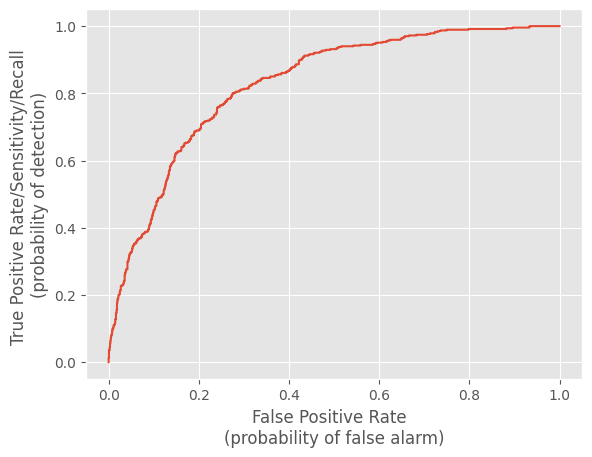

AUC:0.827
Optimal threshold:0.356


In [288]:
# ROC curve
probs = randomForestModel.predict_proba(X_testD)
FP,TP,thresholds = metrics.roc_curve(y_test,probs[:,1])
plt.plot(FP,TP,label="ROC")
plt.xlabel("False Positive Rate  \n(probability of false alarm)")
plt.ylabel("True Positive Rate/Sensitivity/Recall \n(probability of detection)")
cutoff=np.argmax(np.abs(TP-FP)) 
optimal_threshold = thresholds[cutoff]
plt.show()
print("AUC:{0:.3f}".format(metrics.auc(FP, TP)))
print("Optimal threshold:{0:.3f}".format(optimal_threshold))

In [289]:
# Get feature importance
importance = list(randomForestModel.feature_importances_)
# Create tuples with variable and value
feature_importance = [(feature, round(importance, 2)) for feature, importance in zip(list(D.columns), importance)]
# Sort in descend order
feature_importance = sorted(feature_importance, key = lambda D: D[1], reverse = True)
resultsDF = pd.DataFrame(data=feature_importance, columns=['Feature', 'Importance'])
resultsDF

Feature  Importance
0               months_since_purchase        0.10
1               subscription_Two year        0.09
2                     monthly_charges        0.08
3                       total_charges        0.08
4         subscription_Month-to-month        0.07
5               subscription_One year        0.06
6                   has_newest_device        0.04
7                        tech_support        0.04
8                  integration_custom        0.04
9                 integration_dropbox        0.04
10                   group_first_year        0.03
11              group_more_third_year        0.03
12  payment_Bank transfer (automatic)        0.03
13    payment_Credit card (automatic)        0.03
14               payment_Mailed check        0.03
15                 integration_gdrive        0.03
16                             gender        0.02
17                      online_backup        0.02
18            monthly_charge_below_36        0.02
19             integrations_activated        0.01
20                   device_insurance        0.01
21                      send_by_email        0.01
22                       share_screen        0.01
23                  recurring_payment        0.01
24           payment_Electronic check        0.01
25            monthly_charge_below_70        0.01
26            monthly_charge_below_90        0.01
27           monthly_charge_higher_90        0.01
28             total_charge_below_399        0.01
29              purchased_by_employer        0.00
30                  group_second_year        0.00
31                   group_third_year        0.00
32            total_charge_below_1395        0.00
33            total_charge_below_3787        0.00
34           total_charge_higher_3787        0.00

Random Forest seems to suffer the same problems of Decision Trees

## Variable Selection

Using the best variables to develop the models:

In [290]:
# Plotting the variables that have the highest correlation with the target variable
sp = churn.corr()['churn'].abs().sort_values(ascending = False) 

threshold = .30
sp [sp >= threshold]

churn                          1.000000
subscription_Month-to-month    0.405103
months_since_purchase          0.352229
group_first_year               0.317580
integration_dropbox            0.308020
subscription_Two year          0.302253
payment_Electronic check       0.301919
Name: churn, dtype: float64

In [291]:
# Copy of the dataframe for the remaining models, having variable selection applied
N = X.copy(deep=True)

In [292]:
# Using Logistic regression variable selection 10 + target
cols_to_keep = ['churn','subscription_Month-to-month', 'months_since_purchase','group_first_year','integration_dropbox','subscription_Two year','payment_Electronic check']
N = N[cols_to_keep]

In [293]:
# Associating Y with the target variable
y = N['churn']

In [294]:
# Split into train and test
X_train, X_test, y_train, y_test = train_test_split(N, y, test_size=0.25, stratify=y, random_state=123)

In [295]:
# Remove the Target from the training
X_train = X_train.drop(['churn'],1)
X_test = X_test.drop(['churn'],1)

/var/folders/7g/q_2j27sx0031sv8_qdf0n5000000gn/T/ipykernel_1818/1888249836.py:2: FutureWarning:

In a future version of pandas all arguments of DataFrame.drop except for the argument 'labels' will be keyword-only.

/var/folders/7g/q_2j27sx0031sv8_qdf0n5000000gn/T/ipykernel_1818/1888249836.py:3: FutureWarning:

In a future version of pandas all arguments of DataFrame.drop except for the argument 'labels' will be keyword-only.



In [296]:
# Dataframe for scaling
tempDF = N.copy(deep=True)
tempDF.drop(columns='churn', inplace=True)

# Normalize training/test data
scaler = MinMaxScaler(feature_range=(0, 1))
tempDF_scaled = scaler.fit_transform(tempDF)
X_train_scaled = scaler.transform(X_train)
X_test_scaled = scaler.transform(X_test)

In [297]:
# Applyting SMOTE to generare new instances (oversampling)
sm = SMOTE(random_state=123, sampling_strategy=1.0)
X_train_scaled2, y_train2 = sm.fit_resample(X_train_scaled, y_train)

## Neural Networks

In [298]:
#Grid Search for parameter finetuning:
 
grid_param = [{'hidden_layer_sizes':([(4,2),(5,2),(6,2),(7,2),(7,5),(7,6),(8,2),(8,5),(8,6),(9,2),(10,2)]),'random_state':[123]}]
classModel = MLPClassifier(random_state=123)
grid = GridSearchCV(classModel, grid_param, cv=5) #5 fold cross validation (5 folds each of the combinations) 
grid.fit(X_train_scaled2, y_train2)
print("Grid search best parameters: {}".format(grid.best_params_))

Grid search best parameters: {'hidden_layer_sizes': (5, 2), 'random_state': 123}


In [299]:
# Create object and train the model /// MLP Classifier and not regressor as the target is binary and not numeric
nnModel = MLPClassifier(**grid.best_params_)
nnModel.fit(X_train_scaled2, y_train2)

MLPClassifier(hidden_layer_sizes=(5, 2), random_state=123)

In [300]:
# predict y for X_train and X_test
y_pred_train = nnModel.predict(X_train_scaled2) 
y_pred_test = nnModel.predict(X_test_scaled) 

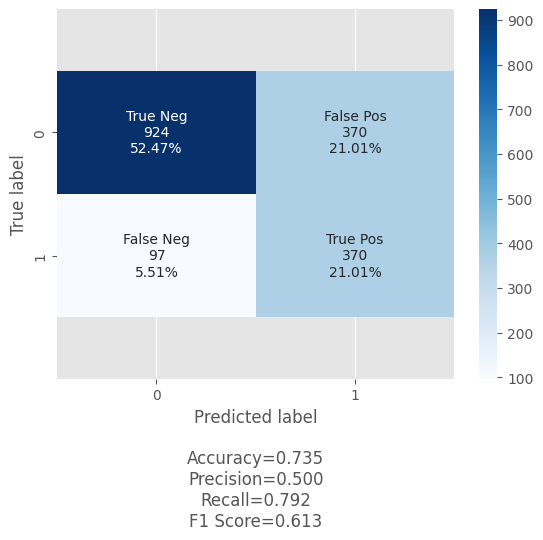

In [301]:
# Show the confusion matrix
cf = metrics.confusion_matrix(y_test,y_pred_test)
labels = ['True Neg','False Pos','False Neg','True Pos']
categories = ['0', '1']
make_confusion_matrix(cf, 
                      group_names=labels,
                      categories=categories, 
                      cmap='Blues')
NeuralNetwork_ConfMatrix = cf

In [302]:
resultsDF = performanceMetricsDF(metrics, y_train2, y_pred_train, y_test, y_pred_test)

NeuralNetwork_Metrics = resultsDF

resultsDF

/var/folders/7g/q_2j27sx0031sv8_qdf0n5000000gn/T/ipykernel_1818/4175523280.py:4: RuntimeWarning:

divide by zero encountered in true_divide

/var/folders/7g/q_2j27sx0031sv8_qdf0n5000000gn/T/ipykernel_1818/4175523280.py:4: RuntimeWarning:

invalid value encountered in true_divide

/var/folders/7g/q_2j27sx0031sv8_qdf0n5000000gn/T/ipykernel_1818/4175523280.py:4: RuntimeWarning:

divide by zero encountered in true_divide

/var/folders/7g/q_2j27sx0031sv8_qdf0n5000000gn/T/ipykernel_1818/4175523280.py:4: RuntimeWarning:

invalid value encountered in true_divide



Measure     Train      Test
0        MAE  0.247036  0.265190
1       RMSE  0.497027  0.514966
2        R^2  0.011856 -0.360896
3   MAPE (%)       NaN       NaN
4  MAX Error  1.000000  1.000000

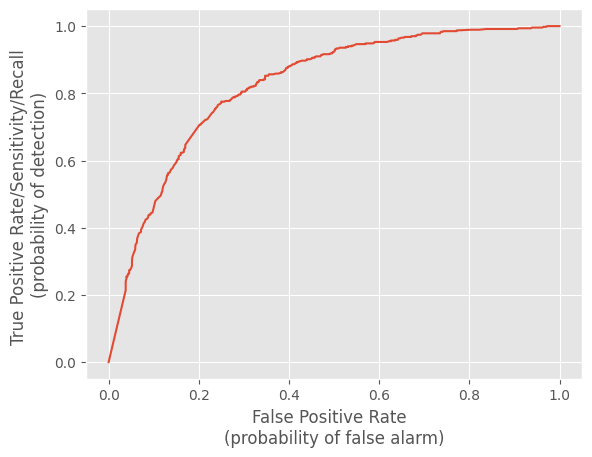

AUC:0.825
Optimal threshold:0.533


In [303]:
# ROC curve
probs = nnModel.predict_proba(X_test_scaled)
FP,TP,thresholds = metrics.roc_curve(y_test,probs[:,1])
plt.plot(FP,TP,label="ROC")
plt.xlabel("False Positive Rate  \n(probability of false alarm)")
plt.ylabel("True Positive Rate/Sensitivity/Recall \n(probability of detection)")
cutoff=np.argmax(np.abs(TP-FP)) 
optimal_threshold = thresholds[cutoff]
plt.show()
print("AUC:{0:.3f}".format(metrics.auc(FP, TP)))
print("Optimal threshold:{0:.3f}".format(optimal_threshold))

Even though Neural Networks has a very bad R Squared, the Recall is the best we have seen so far

## Gaussian Naive Bayes

In [304]:
# Create object and train the model
gaussianModel = GaussianNB()
gaussianModel.fit(X_train_scaled2, y_train2)

GaussianNB()

In [305]:
# predict y for X_train and X_test
y_pred_train = gaussianModel.predict(X_train_scaled2) 
y_pred_test = gaussianModel.predict(X_test) 

/Users/diogodiogo/opt/anaconda3/lib/python3.9/site-packages/sklearn/base.py:432: UserWarning:

X has feature names, but GaussianNB was fitted without feature names



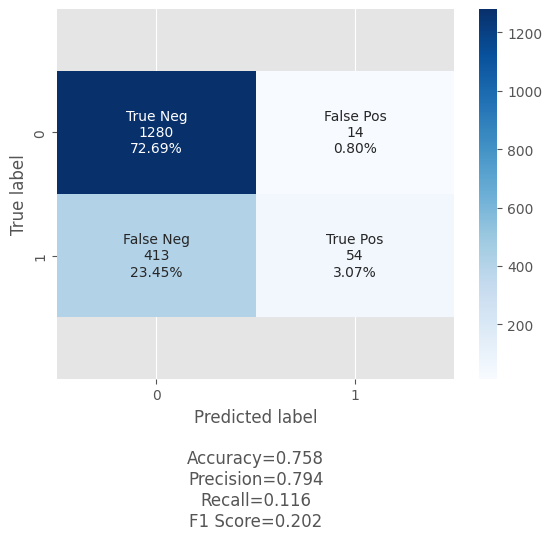

In [306]:
# Show the confusion matrix
cf = metrics.confusion_matrix(y_test,y_pred_test)
labels = ['True Neg','False Pos','False Neg','True Pos']
categories = ['0', '1']
make_confusion_matrix(cf, 
                      group_names=labels,
                      categories=categories, 
                      cmap='Blues')
GaussianModel_ConfMatrix = cf

In [307]:
# Showing error metrics
resultsDF = performanceMetricsDF(metrics, y_train2, y_pred_train, y_test, y_pred_test)

GaussianModel_Metrics = resultsDF

resultsDF

/var/folders/7g/q_2j27sx0031sv8_qdf0n5000000gn/T/ipykernel_1818/4175523280.py:4: RuntimeWarning:

divide by zero encountered in true_divide

/var/folders/7g/q_2j27sx0031sv8_qdf0n5000000gn/T/ipykernel_1818/4175523280.py:4: RuntimeWarning:

invalid value encountered in true_divide

/var/folders/7g/q_2j27sx0031sv8_qdf0n5000000gn/T/ipykernel_1818/4175523280.py:4: RuntimeWarning:

divide by zero encountered in true_divide

/var/folders/7g/q_2j27sx0031sv8_qdf0n5000000gn/T/ipykernel_1818/4175523280.py:4: RuntimeWarning:

invalid value encountered in true_divide



Measure     Train      Test
0        MAE  0.267912  0.242476
1       RMSE  0.517603  0.492418
2        R^2 -0.071649 -0.244331
3   MAPE (%)       NaN       NaN
4  MAX Error  1.000000  1.000000

/Users/diogodiogo/opt/anaconda3/lib/python3.9/site-packages/sklearn/base.py:432: UserWarning:

X has feature names, but GaussianNB was fitted without feature names



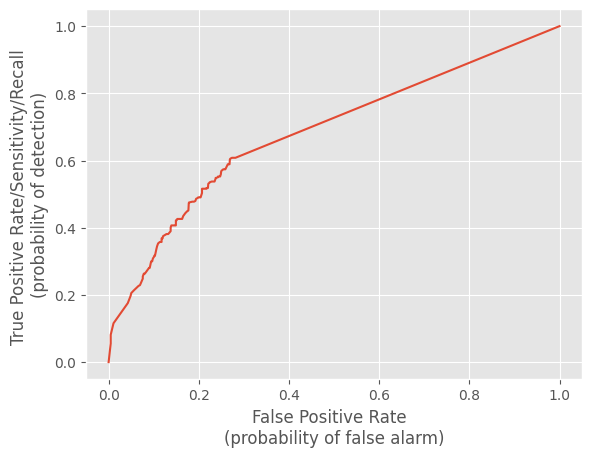

AUC:0.684
Optimal threshold:0.000


In [308]:
# ROC curve
probs = gaussianModel.predict_proba(X_test)
FP,TP,thresholds = metrics.roc_curve(y_test,probs[:,1])
plt.plot(FP,TP,label="ROC")
plt.xlabel("False Positive Rate  \n(probability of false alarm)")
plt.ylabel("True Positive Rate/Sensitivity/Recall \n(probability of detection)")
cutoff=np.argmax(np.abs(TP-FP)) 
optimal_threshold = thresholds[cutoff]
plt.show()
print("AUC:{0:.3f}".format(metrics.auc(FP, TP)))
print("Optimal threshold:{0:.3f}".format(optimal_threshold))

Gaussian Naive Bayes is not a good model, since the AUC is below 0.8, the R Squared is also bad and the recall is the lowest we have seen yet

##### Support Vector Machines

In [309]:
# Create object and train the model
svmModel = svm.SVC(gamma='scale', random_state=123, probability=True) # probability = true for threshold computation in ROC curve
svmModel.fit(X_train_scaled2, y_train2)

SVC(probability=True, random_state=123)

In [310]:
# predict y for X_train and X_test
y_pred_train = svmModel.predict(X_train_scaled2) 
y_pred_test = svmModel.predict(X_test_scaled) 

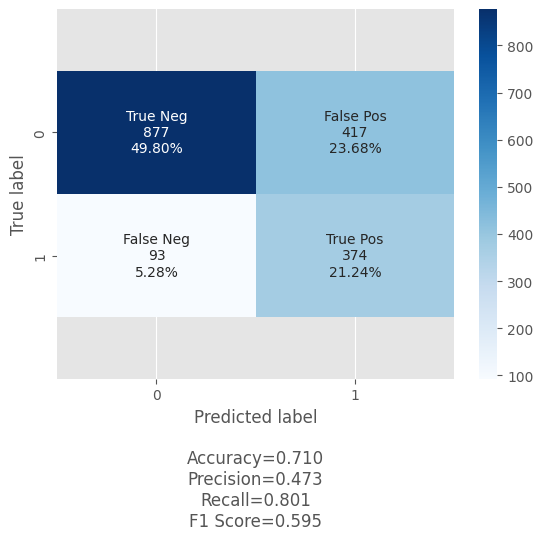

In [311]:
# Show the confusion matrix
cf = metrics.confusion_matrix(y_test,y_pred_test)
labels = ['True Neg','False Pos','False Neg','True Pos']
categories = ['0', '1']
make_confusion_matrix(cf, 
                      group_names=labels,
                      categories=categories, 
                      cmap='Blues')
SupportVectorMachine_ConfMatrix = cf

In [312]:
# Put error metrics in a table
resultsDF = performanceMetricsDF(metrics, y_train2, y_pred_train, y_test, y_pred_test)

SupportVectorMachine_Metrics = resultsDF

resultsDF

/var/folders/7g/q_2j27sx0031sv8_qdf0n5000000gn/T/ipykernel_1818/4175523280.py:4: RuntimeWarning:

divide by zero encountered in true_divide

/var/folders/7g/q_2j27sx0031sv8_qdf0n5000000gn/T/ipykernel_1818/4175523280.py:4: RuntimeWarning:

invalid value encountered in true_divide

/var/folders/7g/q_2j27sx0031sv8_qdf0n5000000gn/T/ipykernel_1818/4175523280.py:4: RuntimeWarning:

divide by zero encountered in true_divide

/var/folders/7g/q_2j27sx0031sv8_qdf0n5000000gn/T/ipykernel_1818/4175523280.py:4: RuntimeWarning:

invalid value encountered in true_divide



Measure     Train      Test
0        MAE  0.245103  0.289608
1       RMSE  0.495079  0.538153
2        R^2  0.019588 -0.486204
3   MAPE (%)       NaN       NaN
4  MAX Error  1.000000  1.000000

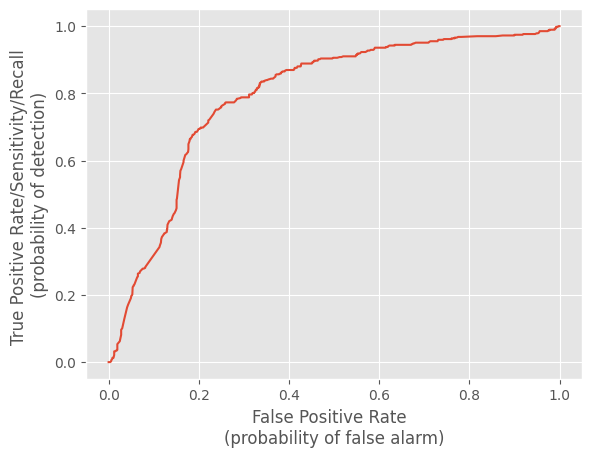

AUC:0.793
Optimal threshold:0.709


In [313]:
# ROC curve
probs = svmModel.predict_proba(X_test_scaled)
FP,TP,thresholds = metrics.roc_curve(y_test,probs[:,1])
plt.plot(FP,TP,label="ROC")
plt.xlabel("False Positive Rate  \n(probability of false alarm)")
plt.ylabel("True Positive Rate/Sensitivity/Recall \n(probability of detection)")
cutoff=np.argmax(np.abs(TP-FP)) 
optimal_threshold = thresholds[cutoff]
plt.show()
print("AUC:{0:.3f}".format(metrics.auc(FP, TP)))
print("Optimal threshold:{0:.3f}".format(optimal_threshold))

Support Vector Machines is tying up with Neural Networks, but has a lower AUC

### K Nearest Neighbors


In [314]:

#Grid Search for parameter fine tuning:
grid_param = [{'n_neighbors': [2,3,4,5,7,9,10,15,25]}] 
classModel = KNeighborsClassifier()
grid = GridSearchCV(classModel, grid_param, cv=5)  
grid.fit(X_train_scaled2, y_train2)
print("Grid search best parameters: {}".format(grid.best_params_))

Grid search best parameters: {'n_neighbors': 25}


In [315]:
# Create object and train the model
knnModel = KNeighborsClassifier(n_neighbors=2)
knnModel.fit(X_train_scaled2, y_train2) # train the model (not training in reality)

KNeighborsClassifier(n_neighbors=2)

In [316]:
# predict y for X_train and X_test
y_pred_train = knnModel.predict(X_train_scaled2) 
y_pred_test = knnModel.predict(X_test_scaled) 

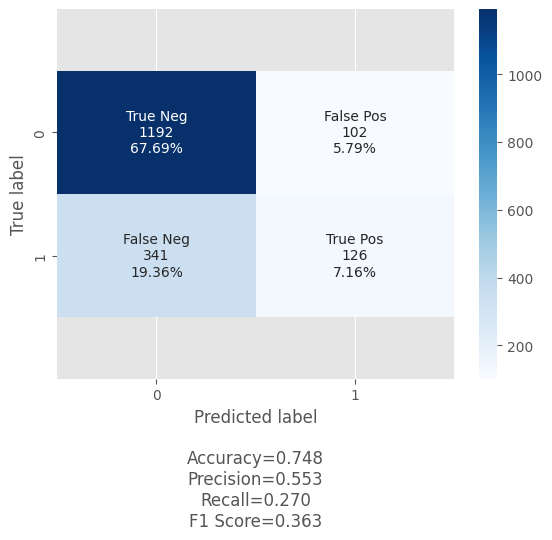

In [317]:
# Show the confusion matrix
cf = metrics.confusion_matrix(y_test,y_pred_test)
labels = ['True Neg','False Pos','False Neg','True Pos']
categories = ['0', '1']
make_confusion_matrix(cf, 
                      group_names=labels,
                      categories=categories, 
                      cmap='Blues')
KNearestNeighbours_ConfMatrix = cf

In [318]:
# Putting into a table the error metrics
resultsDF = performanceMetricsDF(metrics, y_train2, y_pred_train, y_test, y_pred_test)

KNearestNeighbours_Metrics = resultsDF

resultsDF

/var/folders/7g/q_2j27sx0031sv8_qdf0n5000000gn/T/ipykernel_1818/4175523280.py:4: RuntimeWarning:

divide by zero encountered in true_divide

/var/folders/7g/q_2j27sx0031sv8_qdf0n5000000gn/T/ipykernel_1818/4175523280.py:4: RuntimeWarning:

invalid value encountered in true_divide

/var/folders/7g/q_2j27sx0031sv8_qdf0n5000000gn/T/ipykernel_1818/4175523280.py:4: RuntimeWarning:

divide by zero encountered in true_divide

/var/folders/7g/q_2j27sx0031sv8_qdf0n5000000gn/T/ipykernel_1818/4175523280.py:4: RuntimeWarning:

invalid value encountered in true_divide



Measure     Train      Test
0        MAE  0.327706  0.251562
1       RMSE  0.572456  0.501559
2        R^2 -0.310825 -0.290957
3   MAPE (%)       NaN       NaN
4  MAX Error  1.000000  1.000000

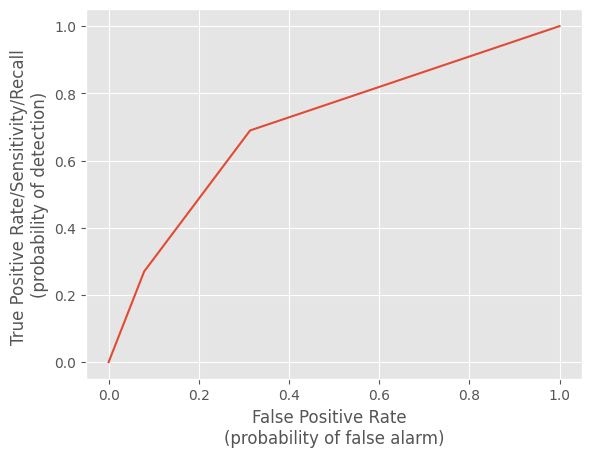

AUC:0.703
Optimal threshold:0.500


In [319]:
# ROC curve
probs = knnModel.predict_proba(X_test_scaled)
FP,TP,thresholds = metrics.roc_curve(y_test,probs[:,1])
plt.plot(FP,TP,label="ROC")
plt.xlabel("False Positive Rate  \n(probability of false alarm)")
plt.ylabel("True Positive Rate/Sensitivity/Recall \n(probability of detection)")
cutoff=np.argmax(np.abs(TP-FP)) 
optimal_threshold = thresholds[cutoff]
plt.show()
print("AUC:{0:.3f}".format(metrics.auc(FP, TP)))
print("Optimal threshold:{0:.3f}".format(optimal_threshold))

It's also a bad model in regards to AUC, R Squared and Recall

## Evaluation

In [320]:
#Settings preparation for the Confusion Matrix display across the 7 models

#Logistic Regression
LogisticRegression_ConfMatrix = pd.DataFrame(LogisticRegression_ConfMatrix, index=['True 0','True 1'],columns=['Predi 0','Predi Label 1'])

#DecisionTree
DecisionTree_ConfMatrix = pd.DataFrame(DecisionTree_ConfMatrix, index=['True 0','True 1'],columns=['Predi 0','Predi Label 1'])

#RandomForest
RandomForest_ConfMatrix = pd.DataFrame(RandomForest_ConfMatrix, index=['True 0','True 1'],columns=['Predi 0','Predi Label 1'])

#NeuralNetwork
NeuralNetwork_ConfMatrix = pd.DataFrame(NeuralNetwork_ConfMatrix, index=['True 0','True 1'],columns=['Predi 0','Predi Label 1'])

#Gaussian NB
GaussianModel_ConfMatrix = pd.DataFrame(GaussianModel_ConfMatrix, index=['True 0','True 1'],columns=['Predi 0','Predi Label 1'])

#SupportVectorMachine
SupportVectorMachine_ConfMatrix = pd.DataFrame(SupportVectorMachine_ConfMatrix, index=['True 0','True 1'],columns=['Predi 0','Predi Label 1'])

#KNearstNeighbours
KNearestNeighbours_ConfMatrix = pd.DataFrame(KNearestNeighbours_ConfMatrix, index=['True 0','True 1'],columns=['Predi 0','Predi Label 1'])

In [321]:
def display_side_by_side(dfs, captions):
    output = ""
    combined = dict(zip(captions, dfs))
    for caption, df in combined.items():
        styled_df = df.style.set_table_attributes("style='display:inline'").set_caption(caption)
        output += styled_df.render()  # Use render() instead of repr_html()
        output += "\xa0\xa0\xa0"
    display(HTML(output))

# Usage
display_side_by_side(
    [KNearestNeighbours_ConfMatrix, RandomForest_ConfMatrix, GaussianModel_ConfMatrix,
     NeuralNetwork_ConfMatrix, LogisticRegression_ConfMatrix, SupportVectorMachine_ConfMatrix,
     DecisionTree_ConfMatrix], 
    ['KNearstNeighbours', 'RandomForest', 'GaussianModel', 'NeuralNetwork', 'LogisticRegression',
     'SupportVectorMachine', 'DecisionTree']
)


/var/folders/7g/q_2j27sx0031sv8_qdf0n5000000gn/T/ipykernel_1818/941323638.py:6: FutureWarning:

this method is deprecated in favour of `Styler.to_html()`



The best models in regard to enhancing recall which is a division of True Positives by True Positivs and False Negatives are:
- Support Vector Machines: (80,1%) <BR>
- Neural Network: (79,2%); <BR>


The other models had:
- Logistic: 77,1% <br>
- Random Forest: 64,7% <br>
- Decision Tree: 62,5% <br>
- KNN: 27% <br>
- Gaussian Naive Bayes: 11,6% <br>

In [322]:
# Metric Comparison
display_side_by_side([KNearestNeighbours_Metrics, RandomForest_Metrics, GaussianModel_Metrics,NeuralNetwork_Metrics,LogisticRegression_Metrics,SupportVectorMachine_Metrics,DecisionTree_Metrics], ['KNearstNeighbours', 'RandomForest', 'GaussianModel','NeuralNetwork','LogisticRegression','SupportVectorMachine', 'DecisionTree'])

/var/folders/7g/q_2j27sx0031sv8_qdf0n5000000gn/T/ipykernel_1818/941323638.py:6: FutureWarning:

this method is deprecated in favour of `Styler.to_html()`



In regards to RMSE, the best models are:
- Gaussian, Neural Network, Logistic Regression, SVM

Also in regards to AUC the classifications were:

- Logistic: 83,1% <br>
- Random Forest: 82,7% <br>
- Neural Network: 82,5% ; <BR>


The other models had:
- Decision Tree: 80,4% <br>
- Support Vector Machines: 79,3%  <BR>
- KNN: 70,3% <br>
- Gaussian Naive Bayes: 68,4%  <br>

Neural Networks seems to be the most consistent model across the different ways to assess the models.

The main variables used on that model were:
- Subscription Month to Month;
- Group first year;
- Integration Dropbox;
- Group Two Years;
- Payment Electronic Check

- The next step would be to look with the product team if there is possibly some kind of problem with the integration with dropbox, some go to ideas would be to see Hotjar recordings to since potential pain points; <br>
- On the side with regards to payment with electronic check and subscription month to month, maybe some interviews can give insights into the psychologic effect of having to pay the subscription every month and possible problems when paying with electronic check; <br>
- In regards to the groups of first year and two years, keep paying attention to the behaviour of first year users which we know are more prone to churn 

How I would improve the model:
Step 1) Gathering new data points
- Usage of the reMarkable App:
	- If users do not use the reMarkable app, the odds of them churning should be probably quite high, so variables such as last open of the app, frequency of usage of the app should be relevant to add;
- Usage of reMarkable: 
	- The usage of reMarkable itself should also be taken into consideration - if they have an average 'session' and if they do not use reMarkable frequently, then it could potentially also be an indicator of churning;
- Interactions with customer service: 
	- If the user has been reporting problems such as 'Desktop app won't sync with reMarkable tablet' it should be an indicator of churn;
- If NPS is asked frequently or other customer satisfaction metric: 
	- If the NPS score drops, it can be used as a proxy for discontent with the product;

Step 2) Doing Feature Engineering
- Create dummy variables depending on the reported issues with customer service;
- Create buckets of users depending of NPS scores;
- Buckets of users depending on average session duration;


Step 3) Improve model performance
- Re-run the model with the inclusion of these new variables, if they have a relevant correlation with the dependent variable;
- Do hyperparameter tuning to find the optimal parameters for the Neural Networks;
- Experiment other algorithms like XGBoost;
- Incorporate Domain Knowledge into feature engineering;